# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

## reading and preparing data

In [ ]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/gans-urdu-news/')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("../dataset/urdu-news-dataset-1M.csv")

In [ ]:
data.head()

,Index,Headline,News Text,Category,Date,URL,Source,News length
0,0,عالمی بینک عسکریت پسندی سے متاثرہ خاندانوں کی ...,اسلام باد عالمی بینک خیبرپختونخوا کے قبائلی اض...,Business & Economics,2020-12-06,https://www.dawnnews.tv/news/1148499/,Dawn News,1854
1,1,مالی سال 2020 ریٹرن فائل کرنے والوں کی تعداد م...,اسلام باد فیڈرل بورڈ ریونیو ایف بی نے دسمبر کی...,Business & Economics,2020-12-06,https://www.dawnnews.tv/news/1148498/,Dawn News,2016
2,2,جاپان کو سندھ کے خصوصی اقتصادی زون میں سرمایہ ...,اسلام باد بورڈ انویسٹمنٹ بی او ئی کے چیئرمین ع...,Business & Economics,2020-12-05,https://www.dawnnews.tv/news/1148433/,Dawn News,2195
3,3,برامدات 767 فیصد بڑھ کر ارب 16 کروڑ ڈالر سے زائد,اسلام اباد پاکستان میں ماہ نومبر میں مسلسل تیس...,Business & Economics,2020-12-05,https://www.dawnnews.tv/news/1148430/,Dawn News,2349
4,4,کے الیکٹرک کو اضافی بجلی گیس کی فراہمی کے قانو...,اسلام باد نیشنل ٹرانسمیشن اینڈ ڈسپیچ کمپنی این...,Business & Economics,2020-12-05,https://www.dawnnews.tv/news/1148421/,Dawn News,2655


In [ ]:
data.Category.unique()

array(['Business & Economics', 'Entertainment', 'Science & Technology',
       'Sports'], dtype=object)

In [ ]:
df_cat = data[data.Category == 'Science & Technology']

In [ ]:
print(df_cat.shape)
df_headline = df_cat['Headline']

(79105, 8)


In [ ]:
df_headline.to_csv('../dataset/headlines/scitech-news-headlines.csv')

In [ ]:
r = pd.read_csv('../dataset/headlines/scitech-news-headlines.csv')
r.head()

,Unnamed: 0,Headline
0,19155,فیس بک کا کووڈ ویکسینز کے خلاف پوسٹس پر کارروا...
1,19156,ایپل کا ملالہ فنڈ کے ساتھ لڑکیوں کی تعلیم موسم...
2,19157,سام سنگ 600 میگا پکسل سنسر کیمرے پر کام کرنے م...
3,19158,امریکی حکومت کا ٹک ٹاک کو مزید مہلت نہ دینے کا...
4,19159,واٹس ایپ ویب ورژن میں اہم ترین فیچر متعارف کرا...


In [ ]:
r.drop(columns=['Unnamed: 0'], inplace=True)
r.head()
df = r

# Setup

In [ ]:
!pip install transformers

In [ ]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
#% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!nvidia-smi

Fri Oct  8 18:23:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/gans-urdu-news/')

Mounted at /content/drive


In [ ]:
filename = '../dataset/headlines/scitech-news-headlines.csv'

In [ ]:
os.getcwd()

'/media/saifhassan/D/GANs/code'

In [ ]:
# copy the data to the current Colab working directory
#!cp $data_dir/$filename .

In [ ]:
# load into a data frame
df = pd.read_csv (filename)  
print(df)

       Unnamed: 0                                           Headline
0           19155  فیس بک کا کووڈ ویکسینز کے خلاف پوسٹس پر کارروا...
1           19156  ایپل کا ملالہ فنڈ کے ساتھ لڑکیوں کی تعلیم موسم...
2           19157  سام سنگ 600 میگا پکسل سنسر کیمرے پر کام کرنے م...
3           19158  امریکی حکومت کا ٹک ٹاک کو مزید مہلت نہ دینے کا...
4           19159  واٹس ایپ ویب ورژن میں اہم ترین فیچر متعارف کرا...
...           ...                                                ...
79100      988153  سندھ بلدیاتی نظام کیخلاف مظاہرے جاری فائرنگ ای...
79101      988154  شاہدرہ موڑ سے غلہ منڈی تک سروس روڈ ٹوٹ پھوٹ کا...
79102      988155  کاہنہ میں تجاوزات کیخلاف پریشن کو سیاسی رنگ دی...
79103      988156  کوئٹہ جھڑپ میں ایف سی اہلکار شدت پسند جاں بحق ...
79104      988157  گستاخانہ فلم ساز پروڈیوسر کو پھانسی دی جائے اف...

[79105 rows x 2 columns]


In [ ]:
df

,Unnamed: 0,Headline
0,19155,فیس بک کا کووڈ ویکسینز کے خلاف پوسٹس پر کارروا...
1,19156,ایپل کا ملالہ فنڈ کے ساتھ لڑکیوں کی تعلیم موسم...
2,19157,سام سنگ 600 میگا پکسل سنسر کیمرے پر کام کرنے م...
3,19158,امریکی حکومت کا ٹک ٹاک کو مزید مہلت نہ دینے کا...
4,19159,واٹس ایپ ویب ورژن میں اہم ترین فیچر متعارف کرا...
...,...,...
79100,988153,سندھ بلدیاتی نظام کیخلاف مظاہرے جاری فائرنگ ای...
79101,988154,شاہدرہ موڑ سے غلہ منڈی تک سروس روڈ ٹوٹ پھوٹ کا...
79102,988155,کاہنہ میں تجاوزات کیخلاف پریشن کو سیاسی رنگ دی...
79103,988156,کوئٹہ جھڑپ میں ایف سی اہلکار شدت پسند جاں بحق ...


In [ ]:
#df.dropna(inplace=True) #remove NA values
reviews = df['Headline'].copy() #just use the main bio text in this example
reviews

0        فیس بک کا کووڈ ویکسینز کے خلاف پوسٹس پر کارروا...
1        ایپل کا ملالہ فنڈ کے ساتھ لڑکیوں کی تعلیم موسم...
2        سام سنگ 600 میگا پکسل سنسر کیمرے پر کام کرنے م...
3        امریکی حکومت کا ٹک ٹاک کو مزید مہلت نہ دینے کا...
4        واٹس ایپ ویب ورژن میں اہم ترین فیچر متعارف کرا...
                               ...                        
79100    سندھ بلدیاتی نظام کیخلاف مظاہرے جاری فائرنگ ای...
79101    شاہدرہ موڑ سے غلہ منڈی تک سروس روڈ ٹوٹ پھوٹ کا...
79102    کاہنہ میں تجاوزات کیخلاف پریشن کو سیاسی رنگ دی...
79103    کوئٹہ جھڑپ میں ایف سی اہلکار شدت پسند جاں بحق ...
79104    گستاخانہ فلم ساز پروڈیوسر کو پھانسی دی جائے اف...
Name: Headline, Length: 79105, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/home/saifhassan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

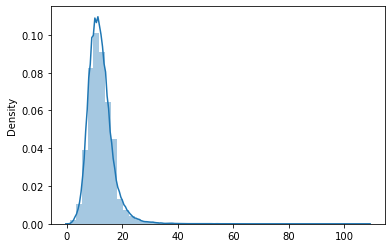

In [ ]:
doc_lengths = []

for review in reviews:

    # get rough token count distribution
    tokens = nltk.word_tokenize(review)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 12])/len(doc_lengths)

0.39218759876114023

In [ ]:
np.average(doc_lengths)

12.031224322103533

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 50 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:

print("The max model length is {} for this model, although the actual embedding size for GPT small is 50".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 50
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [ ]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=12):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(reviews, tokenizer, max_length=12)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

71,194 training samples
7,911 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            #for i, sample_output in enumerate(sample_outputs):
                  #print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  35,597. Loss: 1.721648097038269.   Elapsed: 0:00:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  35,597. Loss: 2.791036367416382.   Elapsed: 0:00:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  35,597. Loss: 1.995130181312561.   Elapsed: 0:00:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  35,597. Loss: 2.4433369636535645.   Elapsed: 0:00:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  35,597. Loss: 2.64186954498291.   Elapsed: 0:00:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  35,597. Loss: 1.8575023412704468.   Elapsed: 0:00:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  35,597. Loss: 2.290076971054077.   Elapsed: 0:00:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  35,597. Loss: 1.4465258121490479.   Elapsed: 0:00:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  35,597. Loss: 2.0716934204101562.   Elapsed: 0:01:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  35,597. Loss: 1.9444884061813354.   Elapsed: 0:01:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  35,597. Loss: 2.1050710678100586.   Elapsed: 0:01:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  35,597. Loss: 1.0401182174682617.   Elapsed: 0:01:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  35,597. Loss: 1.4153153896331787.   Elapsed: 0:01:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  35,597. Loss: 2.4628920555114746.   Elapsed: 0:01:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  35,597. Loss: 1.941726803779602.   Elapsed: 0:01:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  35,597. Loss: 1.8811942338943481.   Elapsed: 0:01:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  35,597. Loss: 1.6960749626159668.   Elapsed: 0:01:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  35,597. Loss: 1.0301992893218994.   Elapsed: 0:02:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  35,597. Loss: 1.3596512079238892.   Elapsed: 0:02:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  35,597. Loss: 1.654889702796936.   Elapsed: 0:02:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  35,597. Loss: 1.1685259342193604.   Elapsed: 0:02:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  35,597. Loss: 2.1497628688812256.   Elapsed: 0:02:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  35,597. Loss: 2.3706159591674805.   Elapsed: 0:02:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  35,597. Loss: 1.044715404510498.   Elapsed: 0:02:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  35,597. Loss: 0.8192335367202759.   Elapsed: 0:02:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  35,597. Loss: 2.212620735168457.   Elapsed: 0:03:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  35,597. Loss: 1.4751808643341064.   Elapsed: 0:03:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  35,597. Loss: 1.1022149324417114.   Elapsed: 0:03:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  35,597. Loss: 2.1718008518218994.   Elapsed: 0:03:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  35,597. Loss: 0.603412389755249.   Elapsed: 0:03:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  35,597. Loss: 1.2762631177902222.   Elapsed: 0:03:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  35,597. Loss: 1.9324034452438354.   Elapsed: 0:03:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  35,597. Loss: 1.838980793952942.   Elapsed: 0:03:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  35,597. Loss: 0.8836154341697693.   Elapsed: 0:04:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  35,597. Loss: 1.986075520515442.   Elapsed: 0:04:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  35,597. Loss: 1.3282338380813599.   Elapsed: 0:04:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  35,597. Loss: 2.5509958267211914.   Elapsed: 0:04:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  35,597. Loss: 1.7111999988555908.   Elapsed: 0:04:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  35,597. Loss: 1.9442477226257324.   Elapsed: 0:04:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  35,597. Loss: 1.7072536945343018.   Elapsed: 0:04:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  35,597. Loss: 0.8738207221031189.   Elapsed: 0:04:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  35,597. Loss: 1.939309000968933.   Elapsed: 0:04:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  35,597. Loss: 1.9240063428878784.   Elapsed: 0:05:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  35,597. Loss: 1.3224745988845825.   Elapsed: 0:05:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  35,597. Loss: 2.5350565910339355.   Elapsed: 0:05:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  35,597. Loss: 1.8045045137405396.   Elapsed: 0:05:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  35,597. Loss: 2.021388292312622.   Elapsed: 0:05:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  35,597. Loss: 0.4805719256401062.   Elapsed: 0:05:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  35,597. Loss: 1.0031864643096924.   Elapsed: 0:05:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  35,597. Loss: 1.4440943002700806.   Elapsed: 0:05:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  35,597. Loss: 2.614727258682251.   Elapsed: 0:05:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  35,597. Loss: 1.699723720550537.   Elapsed: 0:06:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  35,597. Loss: 2.079990863800049.   Elapsed: 0:06:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  35,597. Loss: 1.4411449432373047.   Elapsed: 0:06:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  35,597. Loss: 2.3858871459960938.   Elapsed: 0:06:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  35,597. Loss: 1.492287039756775.   Elapsed: 0:06:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  35,597. Loss: 1.5085052251815796.   Elapsed: 0:06:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  35,597. Loss: 2.044257879257202.   Elapsed: 0:06:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  35,597. Loss: 2.347961664199829.   Elapsed: 0:06:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  35,597. Loss: 1.2038705348968506.   Elapsed: 0:07:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  35,597. Loss: 1.4992632865905762.   Elapsed: 0:07:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  35,597. Loss: 2.480914354324341.   Elapsed: 0:07:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  35,597. Loss: 1.553560733795166.   Elapsed: 0:07:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  35,597. Loss: 2.505610704421997.   Elapsed: 0:07:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  35,597. Loss: 2.033252716064453.   Elapsed: 0:07:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  35,597. Loss: 1.7255514860153198.   Elapsed: 0:07:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  35,597. Loss: 2.3309438228607178.   Elapsed: 0:07:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  35,597. Loss: 1.1719813346862793.   Elapsed: 0:08:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  35,597. Loss: 1.706262469291687.   Elapsed: 0:08:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  35,597. Loss: 2.05721116065979.   Elapsed: 0:08:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  35,597. Loss: 1.6007640361785889.   Elapsed: 0:08:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  35,597. Loss: 1.337342619895935.   Elapsed: 0:08:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  35,597. Loss: 1.0369141101837158.   Elapsed: 0:08:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  35,597. Loss: 0.9384348392486572.   Elapsed: 0:08:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  35,597. Loss: 0.815542459487915.   Elapsed: 0:08:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  35,597. Loss: 0.9158164858818054.   Elapsed: 0:09:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  35,597. Loss: 2.1869957447052.   Elapsed: 0:09:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  35,597. Loss: 3.3194162845611572.   Elapsed: 0:09:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  35,597. Loss: 1.4292782545089722.   Elapsed: 0:09:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  35,597. Loss: 1.8664454221725464.   Elapsed: 0:09:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  35,597. Loss: 1.5275063514709473.   Elapsed: 0:09:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  35,597. Loss: 2.7845535278320312.   Elapsed: 0:09:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  35,597. Loss: 0.6662958860397339.   Elapsed: 0:09:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  35,597. Loss: 2.0921854972839355.   Elapsed: 0:09:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  35,597. Loss: 2.6278746128082275.   Elapsed: 0:10:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  35,597. Loss: 2.122269630432129.   Elapsed: 0:10:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  35,597. Loss: 2.1651899814605713.   Elapsed: 0:10:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  35,597. Loss: 1.4206748008728027.   Elapsed: 0:10:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  35,597. Loss: 1.2582379579544067.   Elapsed: 0:10:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  35,597. Loss: 1.9711905717849731.   Elapsed: 0:10:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  35,597. Loss: 1.4383349418640137.   Elapsed: 0:10:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  35,597. Loss: 1.483838677406311.   Elapsed: 0:10:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  35,597. Loss: 2.295578718185425.   Elapsed: 0:11:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  35,597. Loss: 0.6361044645309448.   Elapsed: 0:11:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  35,597. Loss: 2.138925790786743.   Elapsed: 0:11:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  35,597. Loss: 1.2701658010482788.   Elapsed: 0:11:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  35,597. Loss: 2.103757381439209.   Elapsed: 0:11:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  35,597. Loss: 2.3875527381896973.   Elapsed: 0:11:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  35,597. Loss: 1.3591952323913574.   Elapsed: 0:11:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  35,597. Loss: 1.226394534111023.   Elapsed: 0:11:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  35,597. Loss: 1.527123212814331.   Elapsed: 0:11:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  35,597. Loss: 0.7379782199859619.   Elapsed: 0:12:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  35,597. Loss: 1.82476806640625.   Elapsed: 0:12:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  35,597. Loss: 1.4996975660324097.   Elapsed: 0:12:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  35,597. Loss: 1.7766460180282593.   Elapsed: 0:12:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  35,597. Loss: 2.0348734855651855.   Elapsed: 0:12:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  35,597. Loss: 1.7829384803771973.   Elapsed: 0:12:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  35,597. Loss: 1.6099777221679688.   Elapsed: 0:12:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  35,597. Loss: 2.1612489223480225.   Elapsed: 0:12:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  35,597. Loss: 1.617522120475769.   Elapsed: 0:13:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  35,597. Loss: 1.6167763471603394.   Elapsed: 0:13:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  35,597. Loss: 1.5771021842956543.   Elapsed: 0:13:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  35,597. Loss: 0.7080382108688354.   Elapsed: 0:13:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  35,597. Loss: 1.4342906475067139.   Elapsed: 0:13:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  35,597. Loss: 1.286596655845642.   Elapsed: 0:13:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  35,597. Loss: 2.199789524078369.   Elapsed: 0:13:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  35,597. Loss: 1.3738102912902832.   Elapsed: 0:13:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  35,597. Loss: 1.766628384590149.   Elapsed: 0:13:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  35,597. Loss: 0.6266191005706787.   Elapsed: 0:14:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  35,597. Loss: 0.7346517443656921.   Elapsed: 0:14:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  35,597. Loss: 2.116586923599243.   Elapsed: 0:14:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  35,597. Loss: 1.8332881927490234.   Elapsed: 0:14:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  35,597. Loss: 2.082427740097046.   Elapsed: 0:14:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  35,597. Loss: 2.5085089206695557.   Elapsed: 0:14:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  35,597. Loss: 1.2386243343353271.   Elapsed: 0:14:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  35,597. Loss: 2.022637367248535.   Elapsed: 0:14:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  35,597. Loss: 1.278343915939331.   Elapsed: 0:15:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  35,597. Loss: 1.2563061714172363.   Elapsed: 0:15:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  35,597. Loss: 2.409667730331421.   Elapsed: 0:15:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  35,597. Loss: 1.2103047370910645.   Elapsed: 0:15:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  35,597. Loss: 1.4656716585159302.   Elapsed: 0:15:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  35,597. Loss: 0.8936910033226013.   Elapsed: 0:15:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  35,597. Loss: 1.3632935285568237.   Elapsed: 0:15:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  35,597. Loss: 1.9352812767028809.   Elapsed: 0:15:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  35,597. Loss: 1.9667683839797974.   Elapsed: 0:15:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  35,597. Loss: 1.7709072828292847.   Elapsed: 0:16:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  35,597. Loss: 2.330533981323242.   Elapsed: 0:16:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  35,597. Loss: 2.100196361541748.   Elapsed: 0:16:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  35,597. Loss: 1.2588200569152832.   Elapsed: 0:16:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  35,597. Loss: 1.686861515045166.   Elapsed: 0:16:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  35,597. Loss: 1.3716009855270386.   Elapsed: 0:16:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  35,597. Loss: 1.5180084705352783.   Elapsed: 0:16:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  35,597. Loss: 1.4344520568847656.   Elapsed: 0:16:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  35,597. Loss: 1.3641034364700317.   Elapsed: 0:17:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  35,597. Loss: 2.023672342300415.   Elapsed: 0:17:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  35,597. Loss: 1.4846165180206299.   Elapsed: 0:17:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  35,597. Loss: 2.1177124977111816.   Elapsed: 0:17:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  35,597. Loss: 0.8616867661476135.   Elapsed: 0:17:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  35,597. Loss: 1.8647557497024536.   Elapsed: 0:17:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  35,597. Loss: 1.5602493286132812.   Elapsed: 0:17:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  35,597. Loss: 1.2289968729019165.   Elapsed: 0:17:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  35,597. Loss: 1.268842101097107.   Elapsed: 0:18:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  35,597. Loss: 1.1498483419418335.   Elapsed: 0:18:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  35,597. Loss: 1.5739153623580933.   Elapsed: 0:18:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  35,597. Loss: 2.153278350830078.   Elapsed: 0:18:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  35,597. Loss: 1.6702698469161987.   Elapsed: 0:18:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  35,597. Loss: 1.8652195930480957.   Elapsed: 0:18:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  35,597. Loss: 1.2878601551055908.   Elapsed: 0:18:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,900  of  35,597. Loss: 1.0589219331741333.   Elapsed: 0:18:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,000  of  35,597. Loss: 0.5595690011978149.   Elapsed: 0:18:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,100  of  35,597. Loss: 1.0181667804718018.   Elapsed: 0:19:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,200  of  35,597. Loss: 1.2295340299606323.   Elapsed: 0:19:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,300  of  35,597. Loss: 0.9438820481300354.   Elapsed: 0:19:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,400  of  35,597. Loss: 1.4122663736343384.   Elapsed: 0:19:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,500  of  35,597. Loss: 1.3365836143493652.   Elapsed: 0:19:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,600  of  35,597. Loss: 1.0639525651931763.   Elapsed: 0:19:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,700  of  35,597. Loss: 2.1135873794555664.   Elapsed: 0:19:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,800  of  35,597. Loss: 1.4904932975769043.   Elapsed: 0:19:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,900  of  35,597. Loss: 0.7538774609565735.   Elapsed: 0:20:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,000  of  35,597. Loss: 1.5672764778137207.   Elapsed: 0:20:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,100  of  35,597. Loss: 1.1038281917572021.   Elapsed: 0:20:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,200  of  35,597. Loss: 1.3858636617660522.   Elapsed: 0:20:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,300  of  35,597. Loss: 1.545533299446106.   Elapsed: 0:20:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,400  of  35,597. Loss: 1.7252293825149536.   Elapsed: 0:20:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,500  of  35,597. Loss: 1.7072075605392456.   Elapsed: 0:20:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,600  of  35,597. Loss: 0.8480938076972961.   Elapsed: 0:20:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,700  of  35,597. Loss: 1.494132161140442.   Elapsed: 0:20:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,800  of  35,597. Loss: 1.1464518308639526.   Elapsed: 0:21:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,900  of  35,597. Loss: 1.8542782068252563.   Elapsed: 0:21:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,000  of  35,597. Loss: 2.1972897052764893.   Elapsed: 0:21:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,100  of  35,597. Loss: 1.4171417951583862.   Elapsed: 0:21:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,200  of  35,597. Loss: 1.2078770399093628.   Elapsed: 0:21:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,300  of  35,597. Loss: 1.5291366577148438.   Elapsed: 0:21:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,400  of  35,597. Loss: 0.4335002899169922.   Elapsed: 0:21:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,500  of  35,597. Loss: 1.6873072385787964.   Elapsed: 0:21:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,600  of  35,597. Loss: 1.3007787466049194.   Elapsed: 0:22:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,700  of  35,597. Loss: 1.599876046180725.   Elapsed: 0:22:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,800  of  35,597. Loss: 1.3603652715682983.   Elapsed: 0:22:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,900  of  35,597. Loss: 1.3534784317016602.   Elapsed: 0:22:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,000  of  35,597. Loss: 1.5323779582977295.   Elapsed: 0:22:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,100  of  35,597. Loss: 1.016136646270752.   Elapsed: 0:22:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,200  of  35,597. Loss: 0.9174177646636963.   Elapsed: 0:22:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,300  of  35,597. Loss: 1.0052746534347534.   Elapsed: 0:22:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,400  of  35,597. Loss: 1.6039340496063232.   Elapsed: 0:23:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,500  of  35,597. Loss: 0.6793906688690186.   Elapsed: 0:23:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,600  of  35,597. Loss: 2.1804473400115967.   Elapsed: 0:23:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,700  of  35,597. Loss: 2.05015230178833.   Elapsed: 0:23:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,800  of  35,597. Loss: 0.893894374370575.   Elapsed: 0:23:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,900  of  35,597. Loss: 0.8736721277236938.   Elapsed: 0:23:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,000  of  35,597. Loss: 1.262095332145691.   Elapsed: 0:23:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,100  of  35,597. Loss: 1.5499430894851685.   Elapsed: 0:23:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,200  of  35,597. Loss: 1.653402328491211.   Elapsed: 0:23:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,300  of  35,597. Loss: 2.3053879737854004.   Elapsed: 0:24:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,400  of  35,597. Loss: 1.2162041664123535.   Elapsed: 0:24:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,500  of  35,597. Loss: 1.6112984418869019.   Elapsed: 0:24:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,600  of  35,597. Loss: 1.7792176008224487.   Elapsed: 0:24:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,700  of  35,597. Loss: 0.8582859039306641.   Elapsed: 0:24:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,800  of  35,597. Loss: 1.5649815797805786.   Elapsed: 0:24:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,900  of  35,597. Loss: 1.8963109254837036.   Elapsed: 0:24:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,000  of  35,597. Loss: 1.6356518268585205.   Elapsed: 0:24:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,100  of  35,597. Loss: 1.4181065559387207.   Elapsed: 0:25:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,200  of  35,597. Loss: 0.5152105093002319.   Elapsed: 0:25:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,300  of  35,597. Loss: 1.8726317882537842.   Elapsed: 0:25:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,400  of  35,597. Loss: 1.275551676750183.   Elapsed: 0:25:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,500  of  35,597. Loss: 0.779479444026947.   Elapsed: 0:25:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,600  of  35,597. Loss: 1.395312786102295.   Elapsed: 0:25:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,700  of  35,597. Loss: 2.043341636657715.   Elapsed: 0:25:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,800  of  35,597. Loss: 1.4706171751022339.   Elapsed: 0:25:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,900  of  35,597. Loss: 2.1636979579925537.   Elapsed: 0:25:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,000  of  35,597. Loss: 1.746375560760498.   Elapsed: 0:26:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,100  of  35,597. Loss: 1.0392507314682007.   Elapsed: 0:26:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,200  of  35,597. Loss: 1.5613484382629395.   Elapsed: 0:26:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,300  of  35,597. Loss: 1.7309001684188843.   Elapsed: 0:26:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,400  of  35,597. Loss: 1.3504208326339722.   Elapsed: 0:26:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,500  of  35,597. Loss: 1.2823548316955566.   Elapsed: 0:26:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,600  of  35,597. Loss: 1.0620063543319702.   Elapsed: 0:26:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,700  of  35,597. Loss: 0.8310049176216125.   Elapsed: 0:26:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,800  of  35,597. Loss: 1.7786270380020142.   Elapsed: 0:26:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,900  of  35,597. Loss: 1.2855784893035889.   Elapsed: 0:27:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,000  of  35,597. Loss: 1.1381677389144897.   Elapsed: 0:27:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,100  of  35,597. Loss: 1.2263842821121216.   Elapsed: 0:27:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,200  of  35,597. Loss: 1.43294095993042.   Elapsed: 0:27:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,300  of  35,597. Loss: 1.1312651634216309.   Elapsed: 0:27:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,400  of  35,597. Loss: 2.550006628036499.   Elapsed: 0:27:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,500  of  35,597. Loss: 1.3194466829299927.   Elapsed: 0:27:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,600  of  35,597. Loss: 2.069862127304077.   Elapsed: 0:27:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,700  of  35,597. Loss: 1.1130138635635376.   Elapsed: 0:28:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,800  of  35,597. Loss: 2.1678545475006104.   Elapsed: 0:28:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,900  of  35,597. Loss: 2.114885091781616.   Elapsed: 0:28:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,000  of  35,597. Loss: 1.1130475997924805.   Elapsed: 0:28:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,100  of  35,597. Loss: 1.0788410902023315.   Elapsed: 0:28:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,200  of  35,597. Loss: 1.7561602592468262.   Elapsed: 0:28:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,300  of  35,597. Loss: 1.3561173677444458.   Elapsed: 0:28:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,400  of  35,597. Loss: 1.0445619821548462.   Elapsed: 0:28:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,500  of  35,597. Loss: 1.2222195863723755.   Elapsed: 0:28:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,600  of  35,597. Loss: 1.1240105628967285.   Elapsed: 0:29:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,700  of  35,597. Loss: 1.9187325239181519.   Elapsed: 0:29:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,800  of  35,597. Loss: 1.1853350400924683.   Elapsed: 0:29:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,900  of  35,597. Loss: 1.1913387775421143.   Elapsed: 0:29:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,000  of  35,597. Loss: 2.322333812713623.   Elapsed: 0:29:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,100  of  35,597. Loss: 0.9478921890258789.   Elapsed: 0:29:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,200  of  35,597. Loss: 1.2070213556289673.   Elapsed: 0:29:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,300  of  35,597. Loss: 1.8432719707489014.   Elapsed: 0:29:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,400  of  35,597. Loss: 0.8162683248519897.   Elapsed: 0:30:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,500  of  35,597. Loss: 1.3310720920562744.   Elapsed: 0:30:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,600  of  35,597. Loss: 1.4529553651809692.   Elapsed: 0:30:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,700  of  35,597. Loss: 0.6740816235542297.   Elapsed: 0:30:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,800  of  35,597. Loss: 1.6963928937911987.   Elapsed: 0:30:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,900  of  35,597. Loss: 0.8013246655464172.   Elapsed: 0:30:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,000  of  35,597. Loss: 1.1502814292907715.   Elapsed: 0:30:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,100  of  35,597. Loss: 0.8381726741790771.   Elapsed: 0:30:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,200  of  35,597. Loss: 1.3603181838989258.   Elapsed: 0:30:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,300  of  35,597. Loss: 1.750941514968872.   Elapsed: 0:31:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,400  of  35,597. Loss: 1.7499504089355469.   Elapsed: 0:31:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,500  of  35,597. Loss: 1.8736164569854736.   Elapsed: 0:31:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,600  of  35,597. Loss: 0.6865935921669006.   Elapsed: 0:31:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,700  of  35,597. Loss: 1.525776982307434.   Elapsed: 0:31:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,800  of  35,597. Loss: 1.1306627988815308.   Elapsed: 0:31:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,900  of  35,597. Loss: 1.3607147932052612.   Elapsed: 0:31:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,000  of  35,597. Loss: 1.0571181774139404.   Elapsed: 0:31:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,100  of  35,597. Loss: 1.048231840133667.   Elapsed: 0:32:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,200  of  35,597. Loss: 1.525519609451294.   Elapsed: 0:32:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,300  of  35,597. Loss: 1.0965324640274048.   Elapsed: 0:32:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,400  of  35,597. Loss: 1.699822187423706.   Elapsed: 0:32:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,500  of  35,597. Loss: 1.305815577507019.   Elapsed: 0:32:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,600  of  35,597. Loss: 1.6364688873291016.   Elapsed: 0:32:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,700  of  35,597. Loss: 1.318547010421753.   Elapsed: 0:32:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,800  of  35,597. Loss: 1.665700078010559.   Elapsed: 0:32:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,900  of  35,597. Loss: 1.9406967163085938.   Elapsed: 0:33:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,000  of  35,597. Loss: 1.0055514574050903.   Elapsed: 0:33:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,100  of  35,597. Loss: 1.1795166730880737.   Elapsed: 0:33:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,200  of  35,597. Loss: 1.523078203201294.   Elapsed: 0:33:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,300  of  35,597. Loss: 1.3102768659591675.   Elapsed: 0:33:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,400  of  35,597. Loss: 0.9945605993270874.   Elapsed: 0:33:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,500  of  35,597. Loss: 1.2186685800552368.   Elapsed: 0:33:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,600  of  35,597. Loss: 1.1818240880966187.   Elapsed: 0:33:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,700  of  35,597. Loss: 1.0592783689498901.   Elapsed: 0:33:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,800  of  35,597. Loss: 1.4461004734039307.   Elapsed: 0:34:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,900  of  35,597. Loss: 1.5184184312820435.   Elapsed: 0:34:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,000  of  35,597. Loss: 1.5170493125915527.   Elapsed: 0:34:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,100  of  35,597. Loss: 2.025087594985962.   Elapsed: 0:34:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,200  of  35,597. Loss: 2.352440595626831.   Elapsed: 0:34:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,300  of  35,597. Loss: 1.074934482574463.   Elapsed: 0:34:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,400  of  35,597. Loss: 0.7224701642990112.   Elapsed: 0:34:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,500  of  35,597. Loss: 1.2170205116271973.   Elapsed: 0:34:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,600  of  35,597. Loss: 0.9051890969276428.   Elapsed: 0:35:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,700  of  35,597. Loss: 1.5843760967254639.   Elapsed: 0:35:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,800  of  35,597. Loss: 0.941660463809967.   Elapsed: 0:35:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,900  of  35,597. Loss: 1.1886550188064575.   Elapsed: 0:35:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,000  of  35,597. Loss: 2.3239176273345947.   Elapsed: 0:35:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,100  of  35,597. Loss: 1.3254202604293823.   Elapsed: 0:35:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,200  of  35,597. Loss: 0.969942033290863.   Elapsed: 0:35:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,300  of  35,597. Loss: 1.8129372596740723.   Elapsed: 0:35:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,400  of  35,597. Loss: 1.6408077478408813.   Elapsed: 0:35:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,500  of  35,597. Loss: 1.065463900566101.   Elapsed: 0:36:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,600  of  35,597. Loss: 1.7348953485488892.   Elapsed: 0:36:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,700  of  35,597. Loss: 1.2160253524780273.   Elapsed: 0:36:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,800  of  35,597. Loss: 1.3459060192108154.   Elapsed: 0:36:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,900  of  35,597. Loss: 2.6191306114196777.   Elapsed: 0:36:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,000  of  35,597. Loss: 1.4411553144454956.   Elapsed: 0:36:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,100  of  35,597. Loss: 1.2363667488098145.   Elapsed: 0:36:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,200  of  35,597. Loss: 1.7548352479934692.   Elapsed: 0:36:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,300  of  35,597. Loss: 1.502426266670227.   Elapsed: 0:37:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,400  of  35,597. Loss: 1.699438452720642.   Elapsed: 0:37:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,500  of  35,597. Loss: 1.2872791290283203.   Elapsed: 0:37:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,600  of  35,597. Loss: 1.355699062347412.   Elapsed: 0:37:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,700  of  35,597. Loss: 0.9038398861885071.   Elapsed: 0:37:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,800  of  35,597. Loss: 1.8401061296463013.   Elapsed: 0:37:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,900  of  35,597. Loss: 1.1584649085998535.   Elapsed: 0:37:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,000  of  35,597. Loss: 0.9930481314659119.   Elapsed: 0:37:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,100  of  35,597. Loss: 1.0979770421981812.   Elapsed: 0:37:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,200  of  35,597. Loss: 2.1002273559570312.   Elapsed: 0:38:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,300  of  35,597. Loss: 1.8177546262741089.   Elapsed: 0:38:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,400  of  35,597. Loss: 0.9938195943832397.   Elapsed: 0:38:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,500  of  35,597. Loss: 1.6582732200622559.   Elapsed: 0:38:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,600  of  35,597. Loss: 1.6669760942459106.   Elapsed: 0:38:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,700  of  35,597. Loss: 1.9654393196105957.   Elapsed: 0:38:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,800  of  35,597. Loss: 1.8226609230041504.   Elapsed: 0:38:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,900  of  35,597. Loss: 2.3600990772247314.   Elapsed: 0:38:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,000  of  35,597. Loss: 1.320054292678833.   Elapsed: 0:39:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,100  of  35,597. Loss: 1.328328013420105.   Elapsed: 0:39:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,200  of  35,597. Loss: 1.656425952911377.   Elapsed: 0:39:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,300  of  35,597. Loss: 1.3526908159255981.   Elapsed: 0:39:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,400  of  35,597. Loss: 0.8994632363319397.   Elapsed: 0:39:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,500  of  35,597. Loss: 2.150378465652466.   Elapsed: 0:39:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,600  of  35,597. Loss: 1.2220484018325806.   Elapsed: 0:39:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,700  of  35,597. Loss: 1.4590901136398315.   Elapsed: 0:39:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,800  of  35,597. Loss: 2.0833237171173096.   Elapsed: 0:39:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,900  of  35,597. Loss: 0.9391765594482422.   Elapsed: 0:40:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,000  of  35,597. Loss: 1.5638911724090576.   Elapsed: 0:40:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,100  of  35,597. Loss: 0.7562856078147888.   Elapsed: 0:40:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,200  of  35,597. Loss: 0.7649743556976318.   Elapsed: 0:40:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,300  of  35,597. Loss: 1.6020907163619995.   Elapsed: 0:40:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,400  of  35,597. Loss: 1.1744086742401123.   Elapsed: 0:40:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,500  of  35,597. Loss: 0.9660075902938843.   Elapsed: 0:40:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,600  of  35,597. Loss: 1.6969753503799438.   Elapsed: 0:40:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,700  of  35,597. Loss: 1.8794060945510864.   Elapsed: 0:40:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,800  of  35,597. Loss: 1.9337146282196045.   Elapsed: 0:41:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,900  of  35,597. Loss: 0.6740159392356873.   Elapsed: 0:41:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,000  of  35,597. Loss: 1.2148014307022095.   Elapsed: 0:41:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,100  of  35,597. Loss: 1.2453984022140503.   Elapsed: 0:41:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,200  of  35,597. Loss: 0.7850227355957031.   Elapsed: 0:41:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,300  of  35,597. Loss: 1.0339947938919067.   Elapsed: 0:41:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,400  of  35,597. Loss: 1.3495237827301025.   Elapsed: 0:41:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,500  of  35,597. Loss: 0.9202815890312195.   Elapsed: 0:41:56.

  Average training loss: 1.51
  Training epoch took: 0:42:03

Running Validation...
  Validation Loss: 1.33
  Validation took: 0:00:28

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  35,597. Loss: 1.1869288682937622.   Elapsed: 0:00:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  35,597. Loss: 1.6703846454620361.   Elapsed: 0:00:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  35,597. Loss: 1.7603023052215576.   Elapsed: 0:00:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  35,597. Loss: 0.9831588268280029.   Elapsed: 0:00:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  35,597. Loss: 0.7003441452980042.   Elapsed: 0:00:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  35,597. Loss: 1.842729926109314.   Elapsed: 0:00:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  35,597. Loss: 1.1994749307632446.   Elapsed: 0:00:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  35,597. Loss: 0.8809966444969177.   Elapsed: 0:00:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  35,597. Loss: 2.6137900352478027.   Elapsed: 0:01:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  35,597. Loss: 1.3929314613342285.   Elapsed: 0:01:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  35,597. Loss: 1.490147352218628.   Elapsed: 0:01:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  35,597. Loss: 1.5613682270050049.   Elapsed: 0:01:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  35,597. Loss: 1.7757309675216675.   Elapsed: 0:01:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  35,597. Loss: 1.1619634628295898.   Elapsed: 0:01:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  35,597. Loss: 0.9098709225654602.   Elapsed: 0:01:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  35,597. Loss: 0.6519144773483276.   Elapsed: 0:01:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  35,597. Loss: 1.368026852607727.   Elapsed: 0:01:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  35,597. Loss: 1.0258122682571411.   Elapsed: 0:02:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  35,597. Loss: 2.202164888381958.   Elapsed: 0:02:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  35,597. Loss: 0.725279688835144.   Elapsed: 0:02:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  35,597. Loss: 1.9757078886032104.   Elapsed: 0:02:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  35,597. Loss: 0.7894010543823242.   Elapsed: 0:02:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  35,597. Loss: 1.5087039470672607.   Elapsed: 0:02:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  35,597. Loss: 1.5463448762893677.   Elapsed: 0:02:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  35,597. Loss: 0.8383722305297852.   Elapsed: 0:02:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  35,597. Loss: 1.0595088005065918.   Elapsed: 0:03:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  35,597. Loss: 1.9266756772994995.   Elapsed: 0:03:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  35,597. Loss: 1.4250775575637817.   Elapsed: 0:03:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  35,597. Loss: 1.0347667932510376.   Elapsed: 0:03:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  35,597. Loss: 1.145410418510437.   Elapsed: 0:03:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  35,597. Loss: 1.4133315086364746.   Elapsed: 0:03:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  35,597. Loss: 1.1857045888900757.   Elapsed: 0:03:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  35,597. Loss: 1.495993733406067.   Elapsed: 0:03:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  35,597. Loss: 1.7518534660339355.   Elapsed: 0:04:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  35,597. Loss: 1.7242207527160645.   Elapsed: 0:04:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  35,597. Loss: 0.860807478427887.   Elapsed: 0:04:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  35,597. Loss: 1.0788496732711792.   Elapsed: 0:04:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  35,597. Loss: 1.2632228136062622.   Elapsed: 0:04:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  35,597. Loss: 1.3646128177642822.   Elapsed: 0:04:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  35,597. Loss: 0.7857494354248047.   Elapsed: 0:04:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  35,597. Loss: 1.2572605609893799.   Elapsed: 0:04:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  35,597. Loss: 0.7589933276176453.   Elapsed: 0:04:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  35,597. Loss: 1.4664688110351562.   Elapsed: 0:05:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  35,597. Loss: 2.1705641746520996.   Elapsed: 0:05:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  35,597. Loss: 0.9792312383651733.   Elapsed: 0:05:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  35,597. Loss: 1.5454456806182861.   Elapsed: 0:05:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  35,597. Loss: 1.423604130744934.   Elapsed: 0:05:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  35,597. Loss: 1.7729767560958862.   Elapsed: 0:05:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  35,597. Loss: 0.865649402141571.   Elapsed: 0:05:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  35,597. Loss: 1.2741535902023315.   Elapsed: 0:05:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  35,597. Loss: 1.1625392436981201.   Elapsed: 0:06:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  35,597. Loss: 1.1976017951965332.   Elapsed: 0:06:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  35,597. Loss: 1.5828810930252075.   Elapsed: 0:06:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  35,597. Loss: 1.2544665336608887.   Elapsed: 0:06:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  35,597. Loss: 0.8962118029594421.   Elapsed: 0:06:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  35,597. Loss: 0.9171043038368225.   Elapsed: 0:06:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  35,597. Loss: 1.5584521293640137.   Elapsed: 0:06:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  35,597. Loss: 0.9948211312294006.   Elapsed: 0:06:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  35,597. Loss: 1.3277583122253418.   Elapsed: 0:06:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  35,597. Loss: 1.2390904426574707.   Elapsed: 0:07:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  35,597. Loss: 1.6782993078231812.   Elapsed: 0:07:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  35,597. Loss: 1.1526046991348267.   Elapsed: 0:07:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  35,597. Loss: 0.6138989925384521.   Elapsed: 0:07:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  35,597. Loss: 0.5484089851379395.   Elapsed: 0:07:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  35,597. Loss: 1.195266842842102.   Elapsed: 0:07:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  35,597. Loss: 0.889762282371521.   Elapsed: 0:07:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  35,597. Loss: 0.9968190789222717.   Elapsed: 0:07:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  35,597. Loss: 1.1337116956710815.   Elapsed: 0:08:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  35,597. Loss: 2.1774139404296875.   Elapsed: 0:08:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  35,597. Loss: 0.8619304895401001.   Elapsed: 0:08:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  35,597. Loss: 1.1025036573410034.   Elapsed: 0:08:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  35,597. Loss: 1.2409939765930176.   Elapsed: 0:08:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  35,597. Loss: 1.626200795173645.   Elapsed: 0:08:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  35,597. Loss: 0.938808023929596.   Elapsed: 0:08:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  35,597. Loss: 1.668355107307434.   Elapsed: 0:08:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  35,597. Loss: 1.2291446924209595.   Elapsed: 0:09:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  35,597. Loss: 1.6338766813278198.   Elapsed: 0:09:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  35,597. Loss: 1.2764967679977417.   Elapsed: 0:09:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  35,597. Loss: 1.0674821138381958.   Elapsed: 0:09:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  35,597. Loss: 1.2876251935958862.   Elapsed: 0:09:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  35,597. Loss: 0.5986455678939819.   Elapsed: 0:09:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  35,597. Loss: 1.3628144264221191.   Elapsed: 0:09:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  35,597. Loss: 1.1716798543930054.   Elapsed: 0:09:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  35,597. Loss: 2.4871795177459717.   Elapsed: 0:09:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  35,597. Loss: 0.5549371838569641.   Elapsed: 0:10:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  35,597. Loss: 1.638534426689148.   Elapsed: 0:10:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  35,597. Loss: 2.1111814975738525.   Elapsed: 0:10:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  35,597. Loss: 1.5128045082092285.   Elapsed: 0:10:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  35,597. Loss: 1.1294169425964355.   Elapsed: 0:10:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  35,597. Loss: 0.9506384134292603.   Elapsed: 0:10:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  35,597. Loss: 1.266787052154541.   Elapsed: 0:10:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  35,597. Loss: 1.7602618932724.   Elapsed: 0:10:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  35,597. Loss: 1.2921115159988403.   Elapsed: 0:11:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  35,597. Loss: 1.6798287630081177.   Elapsed: 0:11:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  35,597. Loss: 1.5446929931640625.   Elapsed: 0:11:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  35,597. Loss: 1.5589436292648315.   Elapsed: 0:11:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  35,597. Loss: 0.6223211884498596.   Elapsed: 0:11:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  35,597. Loss: 1.0953196287155151.   Elapsed: 0:11:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  35,597. Loss: 0.931678831577301.   Elapsed: 0:11:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  35,597. Loss: 0.5112384557723999.   Elapsed: 0:11:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  35,597. Loss: 1.3420588970184326.   Elapsed: 0:12:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  35,597. Loss: 0.8168943524360657.   Elapsed: 0:12:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  35,597. Loss: 2.0492823123931885.   Elapsed: 0:12:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  35,597. Loss: 0.9387271404266357.   Elapsed: 0:12:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  35,597. Loss: 1.7145099639892578.   Elapsed: 0:12:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  35,597. Loss: 0.6381762623786926.   Elapsed: 0:12:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  35,597. Loss: 1.0054596662521362.   Elapsed: 0:12:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  35,597. Loss: 0.5569802522659302.   Elapsed: 0:12:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  35,597. Loss: 1.382555365562439.   Elapsed: 0:12:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  35,597. Loss: 1.978949785232544.   Elapsed: 0:13:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  35,597. Loss: 1.3278628587722778.   Elapsed: 0:13:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  35,597. Loss: 1.0888267755508423.   Elapsed: 0:13:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  35,597. Loss: 0.8398752808570862.   Elapsed: 0:13:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  35,597. Loss: 1.3399972915649414.   Elapsed: 0:13:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  35,597. Loss: 1.2110708951950073.   Elapsed: 0:13:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  35,597. Loss: 0.8009567260742188.   Elapsed: 0:13:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  35,597. Loss: 1.1823703050613403.   Elapsed: 0:13:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  35,597. Loss: 1.0118073225021362.   Elapsed: 0:14:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  35,597. Loss: 0.6968629360198975.   Elapsed: 0:14:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  35,597. Loss: 1.3347851037979126.   Elapsed: 0:14:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  35,597. Loss: 0.7671043276786804.   Elapsed: 0:14:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  35,597. Loss: 1.5380713939666748.   Elapsed: 0:14:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  35,597. Loss: 1.8984962701797485.   Elapsed: 0:14:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  35,597. Loss: 1.2587246894836426.   Elapsed: 0:14:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  35,597. Loss: 0.846198320388794.   Elapsed: 0:14:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  35,597. Loss: 1.0831246376037598.   Elapsed: 0:15:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  35,597. Loss: 1.426976203918457.   Elapsed: 0:15:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  35,597. Loss: 1.5634630918502808.   Elapsed: 0:15:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  35,597. Loss: 0.4904933273792267.   Elapsed: 0:15:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  35,597. Loss: 1.1900604963302612.   Elapsed: 0:15:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  35,597. Loss: 1.5848815441131592.   Elapsed: 0:15:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  35,597. Loss: 1.2346161603927612.   Elapsed: 0:15:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  35,597. Loss: 2.350123405456543.   Elapsed: 0:15:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  35,597. Loss: 2.279059410095215.   Elapsed: 0:15:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  35,597. Loss: 1.4422616958618164.   Elapsed: 0:16:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  35,597. Loss: 1.2787866592407227.   Elapsed: 0:16:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  35,597. Loss: 0.4681267738342285.   Elapsed: 0:16:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  35,597. Loss: 0.8052471280097961.   Elapsed: 0:16:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  35,597. Loss: 1.5226349830627441.   Elapsed: 0:16:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  35,597. Loss: 0.6499903202056885.   Elapsed: 0:16:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  35,597. Loss: 1.168472170829773.   Elapsed: 0:16:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  35,597. Loss: 0.8979734778404236.   Elapsed: 0:16:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  35,597. Loss: 0.7190539240837097.   Elapsed: 0:17:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  35,597. Loss: 1.5392943620681763.   Elapsed: 0:17:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  35,597. Loss: 1.917263388633728.   Elapsed: 0:17:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  35,597. Loss: 1.5163365602493286.   Elapsed: 0:17:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  35,597. Loss: 0.8036171197891235.   Elapsed: 0:17:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  35,597. Loss: 1.199539065361023.   Elapsed: 0:17:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  35,597. Loss: 1.1209349632263184.   Elapsed: 0:17:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  35,597. Loss: 1.188468337059021.   Elapsed: 0:17:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  35,597. Loss: 2.046400785446167.   Elapsed: 0:18:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  35,597. Loss: 2.0623652935028076.   Elapsed: 0:18:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  35,597. Loss: 1.3475180864334106.   Elapsed: 0:18:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  35,597. Loss: 1.5750418901443481.   Elapsed: 0:18:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  35,597. Loss: 1.6037236452102661.   Elapsed: 0:18:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  35,597. Loss: 1.4398397207260132.   Elapsed: 0:18:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  35,597. Loss: 1.6757038831710815.   Elapsed: 0:18:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  35,597. Loss: 2.4377593994140625.   Elapsed: 0:18:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,900  of  35,597. Loss: 1.1609485149383545.   Elapsed: 0:19:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,000  of  35,597. Loss: 1.4131370782852173.   Elapsed: 0:19:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,100  of  35,597. Loss: 1.435867190361023.   Elapsed: 0:19:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,200  of  35,597. Loss: 1.1899065971374512.   Elapsed: 0:19:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,300  of  35,597. Loss: 0.962222695350647.   Elapsed: 0:19:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,400  of  35,597. Loss: 2.0021398067474365.   Elapsed: 0:19:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,500  of  35,597. Loss: 0.944602370262146.   Elapsed: 0:19:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,600  of  35,597. Loss: 1.8101119995117188.   Elapsed: 0:19:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,700  of  35,597. Loss: 1.835351586341858.   Elapsed: 0:19:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,800  of  35,597. Loss: 0.7338377237319946.   Elapsed: 0:20:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,900  of  35,597. Loss: 0.6382970809936523.   Elapsed: 0:20:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,000  of  35,597. Loss: 1.1596693992614746.   Elapsed: 0:20:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,100  of  35,597. Loss: 0.637572705745697.   Elapsed: 0:20:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,200  of  35,597. Loss: 1.536109209060669.   Elapsed: 0:20:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,300  of  35,597. Loss: 1.8697521686553955.   Elapsed: 0:20:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,400  of  35,597. Loss: 1.810973048210144.   Elapsed: 0:20:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,500  of  35,597. Loss: 1.1903058290481567.   Elapsed: 0:20:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,600  of  35,597. Loss: 1.2778089046478271.   Elapsed: 0:20:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,700  of  35,597. Loss: 0.5917263627052307.   Elapsed: 0:20:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,800  of  35,597. Loss: 1.0833697319030762.   Elapsed: 0:21:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,900  of  35,597. Loss: 2.3815667629241943.   Elapsed: 0:21:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,000  of  35,597. Loss: 1.6747050285339355.   Elapsed: 0:21:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,100  of  35,597. Loss: 1.4568328857421875.   Elapsed: 0:21:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,200  of  35,597. Loss: 1.3862076997756958.   Elapsed: 0:21:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,300  of  35,597. Loss: 1.8308104276657104.   Elapsed: 0:21:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,400  of  35,597. Loss: 1.2395999431610107.   Elapsed: 0:21:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,500  of  35,597. Loss: 1.7984901666641235.   Elapsed: 0:21:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,600  of  35,597. Loss: 1.1442296504974365.   Elapsed: 0:22:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,700  of  35,597. Loss: 1.027371883392334.   Elapsed: 0:22:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,800  of  35,597. Loss: 1.0783274173736572.   Elapsed: 0:22:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,900  of  35,597. Loss: 1.131049633026123.   Elapsed: 0:22:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,000  of  35,597. Loss: 1.0267199277877808.   Elapsed: 0:22:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,100  of  35,597. Loss: 1.8170615434646606.   Elapsed: 0:22:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,200  of  35,597. Loss: 1.2229613065719604.   Elapsed: 0:22:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,300  of  35,597. Loss: 1.0943962335586548.   Elapsed: 0:22:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,400  of  35,597. Loss: 0.7959079742431641.   Elapsed: 0:22:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,500  of  35,597. Loss: 0.9346972107887268.   Elapsed: 0:22:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,600  of  35,597. Loss: 1.7440053224563599.   Elapsed: 0:23:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,700  of  35,597. Loss: 0.7108606100082397.   Elapsed: 0:23:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,800  of  35,597. Loss: 1.6046881675720215.   Elapsed: 0:23:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,900  of  35,597. Loss: 0.8008162975311279.   Elapsed: 0:23:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,000  of  35,597. Loss: 1.4138585329055786.   Elapsed: 0:23:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,100  of  35,597. Loss: 1.9153087139129639.   Elapsed: 0:23:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,200  of  35,597. Loss: 1.264870524406433.   Elapsed: 0:23:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,300  of  35,597. Loss: 1.4065238237380981.   Elapsed: 0:23:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,400  of  35,597. Loss: 0.8936143517494202.   Elapsed: 0:24:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,500  of  35,597. Loss: 1.5266213417053223.   Elapsed: 0:24:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,600  of  35,597. Loss: 1.0212763547897339.   Elapsed: 0:24:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,700  of  35,597. Loss: 1.6644763946533203.   Elapsed: 0:24:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,800  of  35,597. Loss: 1.071459174156189.   Elapsed: 0:24:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,900  of  35,597. Loss: 0.800601065158844.   Elapsed: 0:24:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,000  of  35,597. Loss: 1.6406208276748657.   Elapsed: 0:24:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,100  of  35,597. Loss: 0.6698082089424133.   Elapsed: 0:24:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,200  of  35,597. Loss: 1.3073809146881104.   Elapsed: 0:25:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,300  of  35,597. Loss: 1.5071322917938232.   Elapsed: 0:25:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,400  of  35,597. Loss: 1.7652283906936646.   Elapsed: 0:25:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,500  of  35,597. Loss: 1.1216639280319214.   Elapsed: 0:25:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,600  of  35,597. Loss: 0.8033288717269897.   Elapsed: 0:25:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,700  of  35,597. Loss: 1.2650898694992065.   Elapsed: 0:25:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,800  of  35,597. Loss: 0.5347639918327332.   Elapsed: 0:25:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,900  of  35,597. Loss: 1.206496000289917.   Elapsed: 0:25:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,000  of  35,597. Loss: 2.03296160697937.   Elapsed: 0:25:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,100  of  35,597. Loss: 1.0271389484405518.   Elapsed: 0:26:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,200  of  35,597. Loss: 1.6942700147628784.   Elapsed: 0:26:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,300  of  35,597. Loss: 1.5992392301559448.   Elapsed: 0:26:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,400  of  35,597. Loss: 1.8840469121932983.   Elapsed: 0:26:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,500  of  35,597. Loss: 1.460261583328247.   Elapsed: 0:26:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,600  of  35,597. Loss: 0.7072229981422424.   Elapsed: 0:26:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,700  of  35,597. Loss: 1.1125695705413818.   Elapsed: 0:26:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,800  of  35,597. Loss: 0.9531270861625671.   Elapsed: 0:26:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,900  of  35,597. Loss: 0.5524706244468689.   Elapsed: 0:27:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,000  of  35,597. Loss: 2.0101125240325928.   Elapsed: 0:27:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,100  of  35,597. Loss: 1.9578464031219482.   Elapsed: 0:27:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,200  of  35,597. Loss: 1.4508599042892456.   Elapsed: 0:27:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,300  of  35,597. Loss: 0.8207929730415344.   Elapsed: 0:27:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,400  of  35,597. Loss: 0.8726158142089844.   Elapsed: 0:27:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,500  of  35,597. Loss: 1.0458790063858032.   Elapsed: 0:27:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,600  of  35,597. Loss: 1.331303596496582.   Elapsed: 0:27:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,700  of  35,597. Loss: 1.1090683937072754.   Elapsed: 0:27:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,800  of  35,597. Loss: 2.0872459411621094.   Elapsed: 0:28:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,900  of  35,597. Loss: 1.0708626508712769.   Elapsed: 0:28:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,000  of  35,597. Loss: 1.693928599357605.   Elapsed: 0:28:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,100  of  35,597. Loss: 1.5361778736114502.   Elapsed: 0:28:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,200  of  35,597. Loss: 1.6053473949432373.   Elapsed: 0:28:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,300  of  35,597. Loss: 1.801553726196289.   Elapsed: 0:28:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,400  of  35,597. Loss: 1.544742465019226.   Elapsed: 0:28:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,500  of  35,597. Loss: 0.5997610688209534.   Elapsed: 0:28:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,600  of  35,597. Loss: 2.00923228263855.   Elapsed: 0:29:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,700  of  35,597. Loss: 0.6801292300224304.   Elapsed: 0:29:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,800  of  35,597. Loss: 0.9862076044082642.   Elapsed: 0:29:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,900  of  35,597. Loss: 1.3312712907791138.   Elapsed: 0:29:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,000  of  35,597. Loss: 0.6827844977378845.   Elapsed: 0:29:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,100  of  35,597. Loss: 0.5870134830474854.   Elapsed: 0:29:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,200  of  35,597. Loss: 1.4781776666641235.   Elapsed: 0:29:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,300  of  35,597. Loss: 1.1310466527938843.   Elapsed: 0:29:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,400  of  35,597. Loss: 0.8231416344642639.   Elapsed: 0:29:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,500  of  35,597. Loss: 1.5698351860046387.   Elapsed: 0:30:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,600  of  35,597. Loss: 1.1295676231384277.   Elapsed: 0:30:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,700  of  35,597. Loss: 1.240179181098938.   Elapsed: 0:30:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,800  of  35,597. Loss: 1.6089739799499512.   Elapsed: 0:30:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,900  of  35,597. Loss: 1.5514229536056519.   Elapsed: 0:30:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,000  of  35,597. Loss: 1.7825549840927124.   Elapsed: 0:30:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,100  of  35,597. Loss: 0.9804040789604187.   Elapsed: 0:30:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,200  of  35,597. Loss: 0.7477731108665466.   Elapsed: 0:30:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,300  of  35,597. Loss: 0.48370400071144104.   Elapsed: 0:30:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,400  of  35,597. Loss: 0.779200553894043.   Elapsed: 0:31:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,500  of  35,597. Loss: 0.5327917337417603.   Elapsed: 0:31:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,600  of  35,597. Loss: 2.235642194747925.   Elapsed: 0:31:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,700  of  35,597. Loss: 1.769588828086853.   Elapsed: 0:31:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,800  of  35,597. Loss: 0.6365062594413757.   Elapsed: 0:31:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,900  of  35,597. Loss: 1.6153302192687988.   Elapsed: 0:31:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,000  of  35,597. Loss: 0.9419432282447815.   Elapsed: 0:31:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,100  of  35,597. Loss: 1.7072514295578003.   Elapsed: 0:31:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,200  of  35,597. Loss: 1.8562391996383667.   Elapsed: 0:32:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,300  of  35,597. Loss: 0.9454113245010376.   Elapsed: 0:32:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,400  of  35,597. Loss: 1.6651016473770142.   Elapsed: 0:32:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,500  of  35,597. Loss: 1.2886496782302856.   Elapsed: 0:32:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,600  of  35,597. Loss: 1.3311281204223633.   Elapsed: 0:32:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,700  of  35,597. Loss: 1.6856765747070312.   Elapsed: 0:32:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,800  of  35,597. Loss: 2.0375757217407227.   Elapsed: 0:32:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,900  of  35,597. Loss: 1.5219173431396484.   Elapsed: 0:32:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,000  of  35,597. Loss: 0.693098783493042.   Elapsed: 0:33:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,100  of  35,597. Loss: 1.5509792566299438.   Elapsed: 0:33:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,200  of  35,597. Loss: 1.6570408344268799.   Elapsed: 0:33:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,300  of  35,597. Loss: 1.4282170534133911.   Elapsed: 0:33:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,400  of  35,597. Loss: 1.4152477979660034.   Elapsed: 0:33:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,500  of  35,597. Loss: 1.25044846534729.   Elapsed: 0:33:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,600  of  35,597. Loss: 0.7136616110801697.   Elapsed: 0:33:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,700  of  35,597. Loss: 0.9386088848114014.   Elapsed: 0:33:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,800  of  35,597. Loss: 0.9213599562644958.   Elapsed: 0:33:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,900  of  35,597. Loss: 1.1660622358322144.   Elapsed: 0:34:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,000  of  35,597. Loss: 0.9957040548324585.   Elapsed: 0:34:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,100  of  35,597. Loss: 1.4719196557998657.   Elapsed: 0:34:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,200  of  35,597. Loss: 0.6474384069442749.   Elapsed: 0:34:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,300  of  35,597. Loss: 1.0500956773757935.   Elapsed: 0:34:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,400  of  35,597. Loss: 1.064561367034912.   Elapsed: 0:34:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,500  of  35,597. Loss: 1.1056689023971558.   Elapsed: 0:34:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,600  of  35,597. Loss: 1.3542498350143433.   Elapsed: 0:34:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,700  of  35,597. Loss: 1.7803725004196167.   Elapsed: 0:34:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,800  of  35,597. Loss: 1.4047216176986694.   Elapsed: 0:35:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,900  of  35,597. Loss: 0.8507764339447021.   Elapsed: 0:35:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,000  of  35,597. Loss: 0.7660400867462158.   Elapsed: 0:35:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,100  of  35,597. Loss: 2.0855624675750732.   Elapsed: 0:35:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,200  of  35,597. Loss: 1.915013074874878.   Elapsed: 0:35:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,300  of  35,597. Loss: 1.5960116386413574.   Elapsed: 0:35:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,400  of  35,597. Loss: 1.135692834854126.   Elapsed: 0:35:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,500  of  35,597. Loss: 0.7233157753944397.   Elapsed: 0:35:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,600  of  35,597. Loss: 2.303361654281616.   Elapsed: 0:36:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,700  of  35,597. Loss: 1.1995306015014648.   Elapsed: 0:36:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,800  of  35,597. Loss: 2.4204437732696533.   Elapsed: 0:36:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,900  of  35,597. Loss: 1.6070526838302612.   Elapsed: 0:36:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,000  of  35,597. Loss: 0.6621478796005249.   Elapsed: 0:36:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,100  of  35,597. Loss: 1.1872841119766235.   Elapsed: 0:36:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,200  of  35,597. Loss: 1.1714075803756714.   Elapsed: 0:36:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,300  of  35,597. Loss: 0.935397744178772.   Elapsed: 0:36:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,400  of  35,597. Loss: 0.934063196182251.   Elapsed: 0:37:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,500  of  35,597. Loss: 1.485701084136963.   Elapsed: 0:37:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,600  of  35,597. Loss: 1.3161741495132446.   Elapsed: 0:37:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,700  of  35,597. Loss: 1.6037014722824097.   Elapsed: 0:37:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,800  of  35,597. Loss: 0.8917220830917358.   Elapsed: 0:37:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,900  of  35,597. Loss: 1.5138968229293823.   Elapsed: 0:37:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,000  of  35,597. Loss: 1.240844964981079.   Elapsed: 0:37:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,100  of  35,597. Loss: 0.5545257329940796.   Elapsed: 0:37:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,200  of  35,597. Loss: 1.974215030670166.   Elapsed: 0:37:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,300  of  35,597. Loss: 1.740228533744812.   Elapsed: 0:38:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,400  of  35,597. Loss: 0.7250574231147766.   Elapsed: 0:38:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,500  of  35,597. Loss: 0.8601253628730774.   Elapsed: 0:38:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,600  of  35,597. Loss: 1.385158896446228.   Elapsed: 0:38:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,700  of  35,597. Loss: 0.917536735534668.   Elapsed: 0:38:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,800  of  35,597. Loss: 1.2561789751052856.   Elapsed: 0:38:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,900  of  35,597. Loss: 1.8754719495773315.   Elapsed: 0:38:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,000  of  35,597. Loss: 1.6453877687454224.   Elapsed: 0:38:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,100  of  35,597. Loss: 0.7859845757484436.   Elapsed: 0:38:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,200  of  35,597. Loss: 1.8665366172790527.   Elapsed: 0:39:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,300  of  35,597. Loss: 0.7390106320381165.   Elapsed: 0:39:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,400  of  35,597. Loss: 1.4946883916854858.   Elapsed: 0:39:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,500  of  35,597. Loss: 1.5884686708450317.   Elapsed: 0:39:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,600  of  35,597. Loss: 1.2963312864303589.   Elapsed: 0:39:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,700  of  35,597. Loss: 0.8800685405731201.   Elapsed: 0:39:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,800  of  35,597. Loss: 1.2653496265411377.   Elapsed: 0:39:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,900  of  35,597. Loss: 1.2475281953811646.   Elapsed: 0:39:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,000  of  35,597. Loss: 0.7294861078262329.   Elapsed: 0:40:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,100  of  35,597. Loss: 1.565191626548767.   Elapsed: 0:40:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,200  of  35,597. Loss: 0.7570545673370361.   Elapsed: 0:40:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,300  of  35,597. Loss: 1.631717324256897.   Elapsed: 0:40:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,400  of  35,597. Loss: 1.1574894189834595.   Elapsed: 0:40:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,500  of  35,597. Loss: 0.7961887717247009.   Elapsed: 0:40:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,600  of  35,597. Loss: 1.3010592460632324.   Elapsed: 0:40:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,700  of  35,597. Loss: 1.9325413703918457.   Elapsed: 0:40:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,800  of  35,597. Loss: 1.7435826063156128.   Elapsed: 0:41:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,900  of  35,597. Loss: 1.293422818183899.   Elapsed: 0:41:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,000  of  35,597. Loss: 1.4613614082336426.   Elapsed: 0:41:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,100  of  35,597. Loss: 0.6386498212814331.   Elapsed: 0:41:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,200  of  35,597. Loss: 0.522289514541626.   Elapsed: 0:41:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,300  of  35,597. Loss: 1.5082660913467407.   Elapsed: 0:41:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,400  of  35,597. Loss: 1.1933643817901611.   Elapsed: 0:41:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,500  of  35,597. Loss: 1.0021395683288574.   Elapsed: 0:41:46.

  Average training loss: 1.29
  Training epoch took: 0:41:52

Running Validation...
  Validation Loss: 1.23
  Validation took: 0:00:29

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  35,597. Loss: 0.9235535264015198.   Elapsed: 0:00:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  35,597. Loss: 1.4520983695983887.   Elapsed: 0:00:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  35,597. Loss: 1.1174925565719604.   Elapsed: 0:00:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  35,597. Loss: 1.1897437572479248.   Elapsed: 0:00:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  35,597. Loss: 1.2905054092407227.   Elapsed: 0:00:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  35,597. Loss: 0.9688706994056702.   Elapsed: 0:00:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  35,597. Loss: 1.4804900884628296.   Elapsed: 0:00:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  35,597. Loss: 0.8420042395591736.   Elapsed: 0:00:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  35,597. Loss: 0.6839911937713623.   Elapsed: 0:01:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  35,597. Loss: 1.077534794807434.   Elapsed: 0:01:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  35,597. Loss: 0.7952476739883423.   Elapsed: 0:01:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  35,597. Loss: 0.7686446905136108.   Elapsed: 0:01:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  35,597. Loss: 2.1058385372161865.   Elapsed: 0:01:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  35,597. Loss: 0.5057563781738281.   Elapsed: 0:01:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  35,597. Loss: 0.7007771134376526.   Elapsed: 0:01:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  35,597. Loss: 2.076448917388916.   Elapsed: 0:01:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  35,597. Loss: 1.5086060762405396.   Elapsed: 0:01:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  35,597. Loss: 2.2013025283813477.   Elapsed: 0:02:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  35,597. Loss: 0.877812385559082.   Elapsed: 0:02:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  35,597. Loss: 1.3761099576950073.   Elapsed: 0:02:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  35,597. Loss: 1.4724369049072266.   Elapsed: 0:02:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  35,597. Loss: 1.6088314056396484.   Elapsed: 0:02:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  35,597. Loss: 1.9878871440887451.   Elapsed: 0:02:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  35,597. Loss: 1.7274177074432373.   Elapsed: 0:02:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  35,597. Loss: 1.6011364459991455.   Elapsed: 0:02:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  35,597. Loss: 1.2963200807571411.   Elapsed: 0:03:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  35,597. Loss: 1.3374104499816895.   Elapsed: 0:03:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  35,597. Loss: 1.6480603218078613.   Elapsed: 0:03:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  35,597. Loss: 1.4125170707702637.   Elapsed: 0:03:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  35,597. Loss: 1.4774733781814575.   Elapsed: 0:03:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  35,597. Loss: 1.416751742362976.   Elapsed: 0:03:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  35,597. Loss: 1.7115013599395752.   Elapsed: 0:03:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  35,597. Loss: 0.8705980777740479.   Elapsed: 0:03:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  35,597. Loss: 1.1305625438690186.   Elapsed: 0:04:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  35,597. Loss: 0.8102970719337463.   Elapsed: 0:04:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  35,597. Loss: 1.5044581890106201.   Elapsed: 0:04:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  35,597. Loss: 0.7188618183135986.   Elapsed: 0:04:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  35,597. Loss: 1.5308610200881958.   Elapsed: 0:04:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  35,597. Loss: 0.6288608312606812.   Elapsed: 0:04:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  35,597. Loss: 0.5525434017181396.   Elapsed: 0:04:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  35,597. Loss: 1.2209274768829346.   Elapsed: 0:04:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  35,597. Loss: 1.0216352939605713.   Elapsed: 0:05:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  35,597. Loss: 0.5282170176506042.   Elapsed: 0:05:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  35,597. Loss: 0.4599820375442505.   Elapsed: 0:05:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  35,597. Loss: 1.035505771636963.   Elapsed: 0:05:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  35,597. Loss: 1.6076507568359375.   Elapsed: 0:05:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  35,597. Loss: 1.1949477195739746.   Elapsed: 0:05:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  35,597. Loss: 1.460769534111023.   Elapsed: 0:05:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  35,597. Loss: 0.643173336982727.   Elapsed: 0:05:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  35,597. Loss: 1.5610923767089844.   Elapsed: 0:05:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  35,597. Loss: 0.8545303344726562.   Elapsed: 0:06:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  35,597. Loss: 1.7140549421310425.   Elapsed: 0:06:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  35,597. Loss: 1.5617034435272217.   Elapsed: 0:06:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  35,597. Loss: 1.8893954753875732.   Elapsed: 0:06:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  35,597. Loss: 1.911359429359436.   Elapsed: 0:06:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  35,597. Loss: 0.9019626975059509.   Elapsed: 0:06:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  35,597. Loss: 1.2719974517822266.   Elapsed: 0:06:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  35,597. Loss: 1.4644389152526855.   Elapsed: 0:06:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  35,597. Loss: 0.8652410507202148.   Elapsed: 0:07:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  35,597. Loss: 1.8732577562332153.   Elapsed: 0:07:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  35,597. Loss: 1.1234707832336426.   Elapsed: 0:07:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  35,597. Loss: 1.2462937831878662.   Elapsed: 0:07:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  35,597. Loss: 1.2102662324905396.   Elapsed: 0:07:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  35,597. Loss: 0.8133015036582947.   Elapsed: 0:07:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  35,597. Loss: 1.2128958702087402.   Elapsed: 0:07:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  35,597. Loss: 0.4991063177585602.   Elapsed: 0:07:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  35,597. Loss: 1.743768334388733.   Elapsed: 0:08:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  35,597. Loss: 0.9074793457984924.   Elapsed: 0:08:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  35,597. Loss: 1.7917466163635254.   Elapsed: 0:08:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  35,597. Loss: 1.385339379310608.   Elapsed: 0:08:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  35,597. Loss: 0.8363580703735352.   Elapsed: 0:08:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  35,597. Loss: 1.660551905632019.   Elapsed: 0:08:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  35,597. Loss: 0.9715142846107483.   Elapsed: 0:08:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  35,597. Loss: 1.121825933456421.   Elapsed: 0:08:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  35,597. Loss: 1.2846479415893555.   Elapsed: 0:09:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  35,597. Loss: 1.0227173566818237.   Elapsed: 0:09:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  35,597. Loss: 1.1257085800170898.   Elapsed: 0:09:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  35,597. Loss: 1.2766835689544678.   Elapsed: 0:09:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  35,597. Loss: 1.393605351448059.   Elapsed: 0:09:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  35,597. Loss: 2.5079123973846436.   Elapsed: 0:09:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  35,597. Loss: 0.8739143013954163.   Elapsed: 0:09:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  35,597. Loss: 0.6291650533676147.   Elapsed: 0:09:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  35,597. Loss: 0.8350827693939209.   Elapsed: 0:09:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  35,597. Loss: 0.7398096323013306.   Elapsed: 0:10:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  35,597. Loss: 0.7516472339630127.   Elapsed: 0:10:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  35,597. Loss: 0.6634334921836853.   Elapsed: 0:10:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  35,597. Loss: 1.7607039213180542.   Elapsed: 0:10:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  35,597. Loss: 1.0214637517929077.   Elapsed: 0:10:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  35,597. Loss: 1.334236979484558.   Elapsed: 0:10:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  35,597. Loss: 1.221294641494751.   Elapsed: 0:10:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  35,597. Loss: 0.5787510871887207.   Elapsed: 0:10:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  35,597. Loss: 1.172073483467102.   Elapsed: 0:10:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  35,597. Loss: 1.1533011198043823.   Elapsed: 0:11:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  35,597. Loss: 2.614600896835327.   Elapsed: 0:11:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  35,597. Loss: 0.6545342803001404.   Elapsed: 0:11:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  35,597. Loss: 0.9193487763404846.   Elapsed: 0:11:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  35,597. Loss: 1.1495327949523926.   Elapsed: 0:11:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  35,597. Loss: 1.2219090461730957.   Elapsed: 0:11:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  35,597. Loss: 1.1504831314086914.   Elapsed: 0:11:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  35,597. Loss: 1.1390478610992432.   Elapsed: 0:11:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  35,597. Loss: 1.9543582201004028.   Elapsed: 0:12:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  35,597. Loss: 0.9668247103691101.   Elapsed: 0:12:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  35,597. Loss: 0.9928691387176514.   Elapsed: 0:12:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  35,597. Loss: 1.773871660232544.   Elapsed: 0:12:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  35,597. Loss: 1.3012727499008179.   Elapsed: 0:12:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  35,597. Loss: 0.814225971698761.   Elapsed: 0:12:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  35,597. Loss: 1.3351624011993408.   Elapsed: 0:12:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  35,597. Loss: 1.5408554077148438.   Elapsed: 0:12:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  35,597. Loss: 1.7165889739990234.   Elapsed: 0:13:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  35,597. Loss: 1.0587128400802612.   Elapsed: 0:13:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  35,597. Loss: 0.5719718337059021.   Elapsed: 0:13:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  35,597. Loss: 1.39046049118042.   Elapsed: 0:13:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  35,597. Loss: 0.9377184510231018.   Elapsed: 0:13:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  35,597. Loss: 0.7135266661643982.   Elapsed: 0:13:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  35,597. Loss: 0.46293628215789795.   Elapsed: 0:13:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  35,597. Loss: 1.6836525201797485.   Elapsed: 0:13:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  35,597. Loss: 1.792723536491394.   Elapsed: 0:14:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  35,597. Loss: 1.4844913482666016.   Elapsed: 0:14:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  35,597. Loss: 1.1077837944030762.   Elapsed: 0:14:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  35,597. Loss: 0.9477869272232056.   Elapsed: 0:14:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  35,597. Loss: 0.7900027632713318.   Elapsed: 0:14:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  35,597. Loss: 0.546597421169281.   Elapsed: 0:14:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  35,597. Loss: 1.1680488586425781.   Elapsed: 0:14:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  35,597. Loss: 1.6889065504074097.   Elapsed: 0:14:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  35,597. Loss: 0.9652311205863953.   Elapsed: 0:14:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  35,597. Loss: 0.8125126361846924.   Elapsed: 0:15:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  35,597. Loss: 0.9595928192138672.   Elapsed: 0:15:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  35,597. Loss: 0.566109299659729.   Elapsed: 0:15:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  35,597. Loss: 0.699734091758728.   Elapsed: 0:15:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  35,597. Loss: 0.8725122809410095.   Elapsed: 0:15:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  35,597. Loss: 1.4724141359329224.   Elapsed: 0:15:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  35,597. Loss: 1.4401015043258667.   Elapsed: 0:15:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  35,597. Loss: 1.5587199926376343.   Elapsed: 0:15:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  35,597. Loss: 1.3860442638397217.   Elapsed: 0:16:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  35,597. Loss: 1.0126701593399048.   Elapsed: 0:16:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  35,597. Loss: 1.2858046293258667.   Elapsed: 0:16:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  35,597. Loss: 1.5933841466903687.   Elapsed: 0:16:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  35,597. Loss: 0.8623161911964417.   Elapsed: 0:16:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  35,597. Loss: 0.7411258816719055.   Elapsed: 0:16:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  35,597. Loss: 0.9569001793861389.   Elapsed: 0:16:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  35,597. Loss: 1.0400363206863403.   Elapsed: 0:16:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  35,597. Loss: 1.0166270732879639.   Elapsed: 0:17:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  35,597. Loss: 1.2608007192611694.   Elapsed: 0:17:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  35,597. Loss: 1.4068182706832886.   Elapsed: 0:17:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  35,597. Loss: 1.2479205131530762.   Elapsed: 0:17:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  35,597. Loss: 1.1771413087844849.   Elapsed: 0:17:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  35,597. Loss: 1.3783282041549683.   Elapsed: 0:17:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  35,597. Loss: 1.1146628856658936.   Elapsed: 0:17:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  35,597. Loss: 1.1735354661941528.   Elapsed: 0:17:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  35,597. Loss: 1.4767528772354126.   Elapsed: 0:17:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  35,597. Loss: 0.9077518582344055.   Elapsed: 0:18:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  35,597. Loss: 1.5487021207809448.   Elapsed: 0:18:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  35,597. Loss: 1.6911858320236206.   Elapsed: 0:18:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  35,597. Loss: 0.7565732598304749.   Elapsed: 0:18:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  35,597. Loss: 0.6896105408668518.   Elapsed: 0:18:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  35,597. Loss: 1.394508957862854.   Elapsed: 0:18:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  35,597. Loss: 1.863861083984375.   Elapsed: 0:18:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  35,597. Loss: 0.9538618326187134.   Elapsed: 0:18:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,900  of  35,597. Loss: 1.7836933135986328.   Elapsed: 0:19:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,000  of  35,597. Loss: 1.7898188829421997.   Elapsed: 0:19:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,100  of  35,597. Loss: 0.7604824304580688.   Elapsed: 0:19:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,200  of  35,597. Loss: 0.9729803204536438.   Elapsed: 0:19:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,300  of  35,597. Loss: 1.5382428169250488.   Elapsed: 0:19:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,400  of  35,597. Loss: 1.8471592664718628.   Elapsed: 0:19:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,500  of  35,597. Loss: 1.5040911436080933.   Elapsed: 0:19:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,600  of  35,597. Loss: 0.6930334568023682.   Elapsed: 0:19:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,700  of  35,597. Loss: 0.4505455791950226.   Elapsed: 0:20:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,800  of  35,597. Loss: 1.5890284776687622.   Elapsed: 0:20:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,900  of  35,597. Loss: 0.965049147605896.   Elapsed: 0:20:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,000  of  35,597. Loss: 0.9435686469078064.   Elapsed: 0:20:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,100  of  35,597. Loss: 0.6851166486740112.   Elapsed: 0:20:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,200  of  35,597. Loss: 1.6351577043533325.   Elapsed: 0:20:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,300  of  35,597. Loss: 0.873295783996582.   Elapsed: 0:20:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,400  of  35,597. Loss: 1.0846896171569824.   Elapsed: 0:20:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,500  of  35,597. Loss: 0.8036006689071655.   Elapsed: 0:20:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,600  of  35,597. Loss: 1.2399709224700928.   Elapsed: 0:21:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,700  of  35,597. Loss: 1.91627836227417.   Elapsed: 0:21:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,800  of  35,597. Loss: 1.7193657159805298.   Elapsed: 0:21:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,900  of  35,597. Loss: 1.421906590461731.   Elapsed: 0:21:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,000  of  35,597. Loss: 0.7294889688491821.   Elapsed: 0:21:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,100  of  35,597. Loss: 0.4574632942676544.   Elapsed: 0:21:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,200  of  35,597. Loss: 1.0887951850891113.   Elapsed: 0:21:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,300  of  35,597. Loss: 0.7288162708282471.   Elapsed: 0:21:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,400  of  35,597. Loss: 0.6061123013496399.   Elapsed: 0:22:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,500  of  35,597. Loss: 0.7936480045318604.   Elapsed: 0:22:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,600  of  35,597. Loss: 1.93165922164917.   Elapsed: 0:22:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,700  of  35,597. Loss: 1.1412383317947388.   Elapsed: 0:22:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,800  of  35,597. Loss: 1.1433643102645874.   Elapsed: 0:22:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,900  of  35,597. Loss: 1.537980318069458.   Elapsed: 0:22:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,000  of  35,597. Loss: 1.541791558265686.   Elapsed: 0:22:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,100  of  35,597. Loss: 0.46369659900665283.   Elapsed: 0:22:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,200  of  35,597. Loss: 0.9581906795501709.   Elapsed: 0:23:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,300  of  35,597. Loss: 1.2105917930603027.   Elapsed: 0:23:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,400  of  35,597. Loss: 1.3256932497024536.   Elapsed: 0:23:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,500  of  35,597. Loss: 0.7866847515106201.   Elapsed: 0:23:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,600  of  35,597. Loss: 1.0387707948684692.   Elapsed: 0:23:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,700  of  35,597. Loss: 1.5621979236602783.   Elapsed: 0:23:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,800  of  35,597. Loss: 0.9854772686958313.   Elapsed: 0:23:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,900  of  35,597. Loss: 1.1538851261138916.   Elapsed: 0:23:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,000  of  35,597. Loss: 1.2766283750534058.   Elapsed: 0:24:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,100  of  35,597. Loss: 0.7608546614646912.   Elapsed: 0:24:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,200  of  35,597. Loss: 1.7047232389450073.   Elapsed: 0:24:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,300  of  35,597. Loss: 1.4736945629119873.   Elapsed: 0:24:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,400  of  35,597. Loss: 1.473120927810669.   Elapsed: 0:24:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,500  of  35,597. Loss: 1.9346861839294434.   Elapsed: 0:24:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,600  of  35,597. Loss: 1.8279474973678589.   Elapsed: 0:24:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,700  of  35,597. Loss: 0.7204697132110596.   Elapsed: 0:24:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,800  of  35,597. Loss: 1.4549576044082642.   Elapsed: 0:24:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,900  of  35,597. Loss: 1.1841262578964233.   Elapsed: 0:25:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,000  of  35,597. Loss: 0.7102896571159363.   Elapsed: 0:25:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,100  of  35,597. Loss: 1.7609854936599731.   Elapsed: 0:25:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,200  of  35,597. Loss: 1.2709765434265137.   Elapsed: 0:25:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,300  of  35,597. Loss: 0.5771446824073792.   Elapsed: 0:25:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,400  of  35,597. Loss: 1.0018187761306763.   Elapsed: 0:25:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,500  of  35,597. Loss: 1.8455427885055542.   Elapsed: 0:25:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,600  of  35,597. Loss: 1.0535197257995605.   Elapsed: 0:25:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,700  of  35,597. Loss: 1.012244462966919.   Elapsed: 0:26:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,800  of  35,597. Loss: 0.5558925867080688.   Elapsed: 0:26:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,900  of  35,597. Loss: 0.8706045746803284.   Elapsed: 0:26:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,000  of  35,597. Loss: 1.7053399085998535.   Elapsed: 0:26:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,100  of  35,597. Loss: 1.3544154167175293.   Elapsed: 0:26:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,200  of  35,597. Loss: 1.8801987171173096.   Elapsed: 0:26:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,300  of  35,597. Loss: 1.6188397407531738.   Elapsed: 0:26:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,400  of  35,597. Loss: 1.4091283082962036.   Elapsed: 0:26:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,500  of  35,597. Loss: 1.1020456552505493.   Elapsed: 0:27:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,600  of  35,597. Loss: 1.2127777338027954.   Elapsed: 0:27:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,700  of  35,597. Loss: 0.6883960962295532.   Elapsed: 0:27:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,800  of  35,597. Loss: 1.0776731967926025.   Elapsed: 0:27:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,900  of  35,597. Loss: 0.8350238800048828.   Elapsed: 0:27:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,000  of  35,597. Loss: 1.0210245847702026.   Elapsed: 0:27:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,100  of  35,597. Loss: 1.1704905033111572.   Elapsed: 0:27:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,200  of  35,597. Loss: 0.7923662662506104.   Elapsed: 0:27:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,300  of  35,597. Loss: 1.3302726745605469.   Elapsed: 0:28:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,400  of  35,597. Loss: 1.2158446311950684.   Elapsed: 0:28:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,500  of  35,597. Loss: 1.312548279762268.   Elapsed: 0:28:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,600  of  35,597. Loss: 1.3155516386032104.   Elapsed: 0:28:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,700  of  35,597. Loss: 0.8746671676635742.   Elapsed: 0:28:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,800  of  35,597. Loss: 1.7100059986114502.   Elapsed: 0:28:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,900  of  35,597. Loss: 1.122276782989502.   Elapsed: 0:28:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,000  of  35,597. Loss: 1.2357515096664429.   Elapsed: 0:28:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,100  of  35,597. Loss: 0.8722343444824219.   Elapsed: 0:28:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,200  of  35,597. Loss: 1.1180921792984009.   Elapsed: 0:29:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,300  of  35,597. Loss: 0.5993402004241943.   Elapsed: 0:29:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,400  of  35,597. Loss: 0.6785902380943298.   Elapsed: 0:29:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,500  of  35,597. Loss: 0.9919439554214478.   Elapsed: 0:29:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,600  of  35,597. Loss: 1.5657273530960083.   Elapsed: 0:29:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,700  of  35,597. Loss: 0.9994401335716248.   Elapsed: 0:29:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,800  of  35,597. Loss: 0.4788782000541687.   Elapsed: 0:29:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,900  of  35,597. Loss: 0.8384609222412109.   Elapsed: 0:29:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,000  of  35,597. Loss: 0.9997929930686951.   Elapsed: 0:30:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,100  of  35,597. Loss: 1.5621176958084106.   Elapsed: 0:30:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,200  of  35,597. Loss: 1.326033353805542.   Elapsed: 0:30:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,300  of  35,597. Loss: 0.7940767407417297.   Elapsed: 0:30:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,400  of  35,597. Loss: 1.0976945161819458.   Elapsed: 0:30:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,500  of  35,597. Loss: 1.8508182764053345.   Elapsed: 0:30:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,600  of  35,597. Loss: 1.256738543510437.   Elapsed: 0:30:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,700  of  35,597. Loss: 1.3695765733718872.   Elapsed: 0:30:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,800  of  35,597. Loss: 1.843095064163208.   Elapsed: 0:31:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,900  of  35,597. Loss: 1.5407723188400269.   Elapsed: 0:31:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,000  of  35,597. Loss: 1.4894070625305176.   Elapsed: 0:31:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,100  of  35,597. Loss: 0.8277224898338318.   Elapsed: 0:31:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,200  of  35,597. Loss: 0.7911505103111267.   Elapsed: 0:31:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,300  of  35,597. Loss: 0.549489438533783.   Elapsed: 0:31:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,400  of  35,597. Loss: 1.100012183189392.   Elapsed: 0:31:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,500  of  35,597. Loss: 1.3809937238693237.   Elapsed: 0:31:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,600  of  35,597. Loss: 1.0971373319625854.   Elapsed: 0:31:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,700  of  35,597. Loss: 0.5738067626953125.   Elapsed: 0:32:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,800  of  35,597. Loss: 1.4210387468338013.   Elapsed: 0:32:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,900  of  35,597. Loss: 0.48625004291534424.   Elapsed: 0:32:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,000  of  35,597. Loss: 1.030916452407837.   Elapsed: 0:32:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,100  of  35,597. Loss: 0.9519327282905579.   Elapsed: 0:32:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,200  of  35,597. Loss: 1.0048702955245972.   Elapsed: 0:32:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,300  of  35,597. Loss: 0.9880179762840271.   Elapsed: 0:32:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,400  of  35,597. Loss: 0.6767567992210388.   Elapsed: 0:32:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,500  of  35,597. Loss: 0.8662631511688232.   Elapsed: 0:33:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,600  of  35,597. Loss: 1.4132194519042969.   Elapsed: 0:33:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,700  of  35,597. Loss: 1.036036729812622.   Elapsed: 0:33:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,800  of  35,597. Loss: 1.2317888736724854.   Elapsed: 0:33:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,900  of  35,597. Loss: 0.8277270793914795.   Elapsed: 0:33:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,000  of  35,597. Loss: 1.5619025230407715.   Elapsed: 0:33:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,100  of  35,597. Loss: 1.3153247833251953.   Elapsed: 0:33:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,200  of  35,597. Loss: 1.0427778959274292.   Elapsed: 0:33:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,300  of  35,597. Loss: 1.2713485956192017.   Elapsed: 0:34:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,400  of  35,597. Loss: 1.1306289434432983.   Elapsed: 0:34:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,500  of  35,597. Loss: 1.2936433553695679.   Elapsed: 0:34:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,600  of  35,597. Loss: 0.8757835030555725.   Elapsed: 0:34:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,700  of  35,597. Loss: 1.3192626237869263.   Elapsed: 0:34:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,800  of  35,597. Loss: 1.5580730438232422.   Elapsed: 0:34:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,900  of  35,597. Loss: 1.3249304294586182.   Elapsed: 0:34:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,000  of  35,597. Loss: 0.9000839591026306.   Elapsed: 0:34:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,100  of  35,597. Loss: 1.2202900648117065.   Elapsed: 0:34:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,200  of  35,597. Loss: 1.0298041105270386.   Elapsed: 0:35:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,300  of  35,597. Loss: 2.1377246379852295.   Elapsed: 0:35:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,400  of  35,597. Loss: 1.5052180290222168.   Elapsed: 0:35:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,500  of  35,597. Loss: 0.9403894543647766.   Elapsed: 0:35:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,600  of  35,597. Loss: 0.9421243071556091.   Elapsed: 0:35:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,700  of  35,597. Loss: 0.9520883560180664.   Elapsed: 0:35:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,800  of  35,597. Loss: 0.6302239894866943.   Elapsed: 0:35:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,900  of  35,597. Loss: 0.45364657044410706.   Elapsed: 0:35:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,000  of  35,597. Loss: 0.6820905208587646.   Elapsed: 0:36:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,100  of  35,597. Loss: 0.5120593905448914.   Elapsed: 0:36:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,200  of  35,597. Loss: 1.002557635307312.   Elapsed: 0:36:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,300  of  35,597. Loss: 1.5825366973876953.   Elapsed: 0:36:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,400  of  35,597. Loss: 0.4721914529800415.   Elapsed: 0:36:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,500  of  35,597. Loss: 1.3086028099060059.   Elapsed: 0:36:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,600  of  35,597. Loss: 0.4953858554363251.   Elapsed: 0:36:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,700  of  35,597. Loss: 1.8169506788253784.   Elapsed: 0:36:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,800  of  35,597. Loss: 0.801086962223053.   Elapsed: 0:37:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,900  of  35,597. Loss: 0.8296937346458435.   Elapsed: 0:37:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,000  of  35,597. Loss: 1.5577785968780518.   Elapsed: 0:37:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,100  of  35,597. Loss: 1.3798267841339111.   Elapsed: 0:37:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,200  of  35,597. Loss: 1.511173963546753.   Elapsed: 0:37:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,300  of  35,597. Loss: 1.3145595788955688.   Elapsed: 0:37:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,400  of  35,597. Loss: 0.9692556262016296.   Elapsed: 0:37:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,500  of  35,597. Loss: 0.7677520513534546.   Elapsed: 0:37:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,600  of  35,597. Loss: 0.553566575050354.   Elapsed: 0:38:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,700  of  35,597. Loss: 0.6441744565963745.   Elapsed: 0:38:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,800  of  35,597. Loss: 1.2972537279129028.   Elapsed: 0:38:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,900  of  35,597. Loss: 1.237221598625183.   Elapsed: 0:38:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,000  of  35,597. Loss: 1.6660994291305542.   Elapsed: 0:38:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,100  of  35,597. Loss: 1.673295259475708.   Elapsed: 0:38:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,200  of  35,597. Loss: 0.9706951379776001.   Elapsed: 0:38:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,300  of  35,597. Loss: 1.4650989770889282.   Elapsed: 0:38:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,400  of  35,597. Loss: 1.5876903533935547.   Elapsed: 0:38:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,500  of  35,597. Loss: 0.8903964757919312.   Elapsed: 0:38:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,600  of  35,597. Loss: 0.9790283441543579.   Elapsed: 0:39:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,700  of  35,597. Loss: 1.2219758033752441.   Elapsed: 0:39:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,800  of  35,597. Loss: 1.7761608362197876.   Elapsed: 0:39:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,900  of  35,597. Loss: 1.9137359857559204.   Elapsed: 0:39:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,000  of  35,597. Loss: 1.2999202013015747.   Elapsed: 0:39:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,100  of  35,597. Loss: 0.9626869559288025.   Elapsed: 0:39:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,200  of  35,597. Loss: 0.5247230529785156.   Elapsed: 0:39:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,300  of  35,597. Loss: 1.3958109617233276.   Elapsed: 0:39:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,400  of  35,597. Loss: 0.49378111958503723.   Elapsed: 0:39:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,500  of  35,597. Loss: 1.5011253356933594.   Elapsed: 0:39:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,600  of  35,597. Loss: 0.6130731701850891.   Elapsed: 0:40:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,700  of  35,597. Loss: 0.5104195475578308.   Elapsed: 0:40:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,800  of  35,597. Loss: 0.6878209710121155.   Elapsed: 0:40:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,900  of  35,597. Loss: 1.0471463203430176.   Elapsed: 0:40:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,000  of  35,597. Loss: 1.930146336555481.   Elapsed: 0:40:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,100  of  35,597. Loss: 1.2412623167037964.   Elapsed: 0:40:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,200  of  35,597. Loss: 1.2670533657073975.   Elapsed: 0:40:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,300  of  35,597. Loss: 0.5709739923477173.   Elapsed: 0:40:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,400  of  35,597. Loss: 1.299553632736206.   Elapsed: 0:40:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,500  of  35,597. Loss: 1.4822312593460083.   Elapsed: 0:40:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,600  of  35,597. Loss: 0.5704619288444519.   Elapsed: 0:41:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,700  of  35,597. Loss: 1.0302449464797974.   Elapsed: 0:41:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,800  of  35,597. Loss: 1.0332088470458984.   Elapsed: 0:41:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,900  of  35,597. Loss: 0.998221755027771.   Elapsed: 0:41:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,000  of  35,597. Loss: 1.6854811906814575.   Elapsed: 0:41:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,100  of  35,597. Loss: 1.2189346551895142.   Elapsed: 0:41:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,200  of  35,597. Loss: 0.9800993204116821.   Elapsed: 0:41:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,300  of  35,597. Loss: 1.0226333141326904.   Elapsed: 0:41:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,400  of  35,597. Loss: 1.1254944801330566.   Elapsed: 0:42:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,500  of  35,597. Loss: 2.6329522132873535.   Elapsed: 0:42:06.

  Average training loss: 1.20
  Training epoch took: 0:42:12

Running Validation...
  Validation Loss: 1.17
  Validation took: 0:00:29

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  35,597. Loss: 1.0827621221542358.   Elapsed: 0:00:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  35,597. Loss: 1.1987789869308472.   Elapsed: 0:00:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  35,597. Loss: 1.1587239503860474.   Elapsed: 0:00:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  35,597. Loss: 0.7841923236846924.   Elapsed: 0:00:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  35,597. Loss: 0.8782106637954712.   Elapsed: 0:00:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  35,597. Loss: 1.1816325187683105.   Elapsed: 0:00:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  35,597. Loss: 0.9616383910179138.   Elapsed: 0:00:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  35,597. Loss: 0.8493828177452087.   Elapsed: 0:00:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  35,597. Loss: 1.4345502853393555.   Elapsed: 0:01:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  35,597. Loss: 1.068907618522644.   Elapsed: 0:01:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  35,597. Loss: 1.0587611198425293.   Elapsed: 0:01:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  35,597. Loss: 0.9309377074241638.   Elapsed: 0:01:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  35,597. Loss: 0.8248792886734009.   Elapsed: 0:01:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  35,597. Loss: 0.9806463718414307.   Elapsed: 0:01:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  35,597. Loss: 1.1138373613357544.   Elapsed: 0:01:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  35,597. Loss: 0.5879654288291931.   Elapsed: 0:01:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  35,597. Loss: 0.9748892188072205.   Elapsed: 0:02:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  35,597. Loss: 0.857917070388794.   Elapsed: 0:02:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  35,597. Loss: 0.8784037232398987.   Elapsed: 0:02:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  35,597. Loss: 0.42397165298461914.   Elapsed: 0:02:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  35,597. Loss: 0.6487882137298584.   Elapsed: 0:02:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  35,597. Loss: 1.1835013628005981.   Elapsed: 0:02:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  35,597. Loss: 1.0099890232086182.   Elapsed: 0:02:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  35,597. Loss: 1.6286265850067139.   Elapsed: 0:02:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  35,597. Loss: 1.372670292854309.   Elapsed: 0:02:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  35,597. Loss: 1.5262279510498047.   Elapsed: 0:03:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  35,597. Loss: 1.5479984283447266.   Elapsed: 0:03:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  35,597. Loss: 1.1007988452911377.   Elapsed: 0:03:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  35,597. Loss: 0.5102528929710388.   Elapsed: 0:03:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  35,597. Loss: 1.304195523262024.   Elapsed: 0:03:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  35,597. Loss: 1.334412932395935.   Elapsed: 0:03:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  35,597. Loss: 1.9443820714950562.   Elapsed: 0:03:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  35,597. Loss: 1.7239199876785278.   Elapsed: 0:03:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  35,597. Loss: 1.971166968345642.   Elapsed: 0:04:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  35,597. Loss: 1.4887691736221313.   Elapsed: 0:04:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  35,597. Loss: 1.5997211933135986.   Elapsed: 0:04:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  35,597. Loss: 0.6904127597808838.   Elapsed: 0:04:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  35,597. Loss: 0.7743081450462341.   Elapsed: 0:04:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  35,597. Loss: 1.2820098400115967.   Elapsed: 0:04:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  35,597. Loss: 2.1604809761047363.   Elapsed: 0:04:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  35,597. Loss: 0.6174132823944092.   Elapsed: 0:04:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  35,597. Loss: 0.4091418981552124.   Elapsed: 0:04:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  35,597. Loss: 0.8836554884910583.   Elapsed: 0:05:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  35,597. Loss: 0.9366588592529297.   Elapsed: 0:05:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  35,597. Loss: 1.6647995710372925.   Elapsed: 0:05:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  35,597. Loss: 1.2073041200637817.   Elapsed: 0:05:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  35,597. Loss: 0.7069942951202393.   Elapsed: 0:05:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  35,597. Loss: 0.6548209190368652.   Elapsed: 0:05:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  35,597. Loss: 1.0304198265075684.   Elapsed: 0:05:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  35,597. Loss: 0.9950783252716064.   Elapsed: 0:05:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  35,597. Loss: 1.6352550983428955.   Elapsed: 0:06:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  35,597. Loss: 0.6974748373031616.   Elapsed: 0:06:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  35,597. Loss: 1.0418565273284912.   Elapsed: 0:06:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  35,597. Loss: 1.6345728635787964.   Elapsed: 0:06:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  35,597. Loss: 1.1855673789978027.   Elapsed: 0:06:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  35,597. Loss: 0.709632158279419.   Elapsed: 0:06:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  35,597. Loss: 0.5016395449638367.   Elapsed: 0:06:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  35,597. Loss: 1.2418503761291504.   Elapsed: 0:06:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  35,597. Loss: 0.9415463805198669.   Elapsed: 0:07:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  35,597. Loss: 1.3578295707702637.   Elapsed: 0:07:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  35,597. Loss: 0.7327322363853455.   Elapsed: 0:07:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  35,597. Loss: 1.1522672176361084.   Elapsed: 0:07:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  35,597. Loss: 0.8694705367088318.   Elapsed: 0:07:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  35,597. Loss: 1.1242671012878418.   Elapsed: 0:07:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  35,597. Loss: 1.687821626663208.   Elapsed: 0:07:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  35,597. Loss: 1.6084946393966675.   Elapsed: 0:07:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  35,597. Loss: 0.5412095189094543.   Elapsed: 0:08:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  35,597. Loss: 1.7422053813934326.   Elapsed: 0:08:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  35,597. Loss: 1.9383801221847534.   Elapsed: 0:08:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  35,597. Loss: 1.2774523496627808.   Elapsed: 0:08:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  35,597. Loss: 1.395113468170166.   Elapsed: 0:08:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  35,597. Loss: 0.6169138550758362.   Elapsed: 0:08:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  35,597. Loss: 1.2012560367584229.   Elapsed: 0:08:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  35,597. Loss: 0.8460429906845093.   Elapsed: 0:08:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  35,597. Loss: 0.9384260773658752.   Elapsed: 0:08:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  35,597. Loss: 0.9452834725379944.   Elapsed: 0:09:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  35,597. Loss: 1.5020710229873657.   Elapsed: 0:09:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  35,597. Loss: 1.14683198928833.   Elapsed: 0:09:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  35,597. Loss: 1.4221056699752808.   Elapsed: 0:09:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  35,597. Loss: 1.1559678316116333.   Elapsed: 0:09:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  35,597. Loss: 2.125117778778076.   Elapsed: 0:09:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  35,597. Loss: 1.0169150829315186.   Elapsed: 0:09:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  35,597. Loss: 1.2947945594787598.   Elapsed: 0:09:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  35,597. Loss: 1.0353039503097534.   Elapsed: 0:09:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  35,597. Loss: 1.0374388694763184.   Elapsed: 0:10:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  35,597. Loss: 0.767133355140686.   Elapsed: 0:10:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  35,597. Loss: 1.5326656103134155.   Elapsed: 0:10:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  35,597. Loss: 1.1644152402877808.   Elapsed: 0:10:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  35,597. Loss: 1.181430459022522.   Elapsed: 0:10:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  35,597. Loss: 1.5696884393692017.   Elapsed: 0:10:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  35,597. Loss: 1.2389347553253174.   Elapsed: 0:10:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  35,597. Loss: 1.2252064943313599.   Elapsed: 0:10:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  35,597. Loss: 1.2567707300186157.   Elapsed: 0:10:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  35,597. Loss: 1.1883052587509155.   Elapsed: 0:11:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  35,597. Loss: 0.9203909039497375.   Elapsed: 0:11:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  35,597. Loss: 1.1719560623168945.   Elapsed: 0:11:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  35,597. Loss: 1.553369164466858.   Elapsed: 0:11:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  35,597. Loss: 1.0414677858352661.   Elapsed: 0:11:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  35,597. Loss: 1.1644597053527832.   Elapsed: 0:11:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  35,597. Loss: 1.150722622871399.   Elapsed: 0:11:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  35,597. Loss: 0.7576992511749268.   Elapsed: 0:11:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  35,597. Loss: 1.6344550848007202.   Elapsed: 0:12:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  35,597. Loss: 1.3572824001312256.   Elapsed: 0:12:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  35,597. Loss: 1.0280015468597412.   Elapsed: 0:12:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  35,597. Loss: 1.8794642686843872.   Elapsed: 0:12:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  35,597. Loss: 1.980116605758667.   Elapsed: 0:12:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  35,597. Loss: 1.4362317323684692.   Elapsed: 0:12:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  35,597. Loss: 1.798416256904602.   Elapsed: 0:12:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  35,597. Loss: 0.5275838971138.   Elapsed: 0:12:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  35,597. Loss: 0.5168368816375732.   Elapsed: 0:12:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  35,597. Loss: 2.091979742050171.   Elapsed: 0:12:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  35,597. Loss: 1.097182035446167.   Elapsed: 0:13:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  35,597. Loss: 1.2094403505325317.   Elapsed: 0:13:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  35,597. Loss: 0.6597341895103455.   Elapsed: 0:13:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  35,597. Loss: 0.5636802315711975.   Elapsed: 0:13:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  35,597. Loss: 0.806745171546936.   Elapsed: 0:13:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  35,597. Loss: 0.7193372249603271.   Elapsed: 0:13:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  35,597. Loss: 1.0889397859573364.   Elapsed: 0:13:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  35,597. Loss: 1.5450561046600342.   Elapsed: 0:13:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  35,597. Loss: 1.389095425605774.   Elapsed: 0:14:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  35,597. Loss: 0.8755388259887695.   Elapsed: 0:14:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  35,597. Loss: 0.7568963766098022.   Elapsed: 0:14:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  35,597. Loss: 0.8862874507904053.   Elapsed: 0:14:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  35,597. Loss: 0.9384281635284424.   Elapsed: 0:14:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  35,597. Loss: 0.9944782257080078.   Elapsed: 0:14:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  35,597. Loss: 0.5703661441802979.   Elapsed: 0:14:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  35,597. Loss: 1.1744160652160645.   Elapsed: 0:14:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  35,597. Loss: 1.2075817584991455.   Elapsed: 0:15:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  35,597. Loss: 1.3913803100585938.   Elapsed: 0:15:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  35,597. Loss: 1.2891006469726562.   Elapsed: 0:15:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  35,597. Loss: 1.2526527643203735.   Elapsed: 0:15:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  35,597. Loss: 1.3309959173202515.   Elapsed: 0:15:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  35,597. Loss: 1.2812672853469849.   Elapsed: 0:15:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  35,597. Loss: 1.8261966705322266.   Elapsed: 0:15:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  35,597. Loss: 0.866593599319458.   Elapsed: 0:15:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  35,597. Loss: 0.5678638219833374.   Elapsed: 0:16:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  35,597. Loss: 1.7786757946014404.   Elapsed: 0:16:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  35,597. Loss: 1.0184210538864136.   Elapsed: 0:16:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  35,597. Loss: 1.6897794008255005.   Elapsed: 0:16:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  35,597. Loss: 1.5544261932373047.   Elapsed: 0:16:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  35,597. Loss: 1.402245044708252.   Elapsed: 0:16:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  35,597. Loss: 1.5142611265182495.   Elapsed: 0:16:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  35,597. Loss: 1.4345873594284058.   Elapsed: 0:16:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  35,597. Loss: 1.3330693244934082.   Elapsed: 0:16:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  35,597. Loss: 0.8919732570648193.   Elapsed: 0:17:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  35,597. Loss: 2.01808500289917.   Elapsed: 0:17:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  35,597. Loss: 1.4620331525802612.   Elapsed: 0:17:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  35,597. Loss: 1.710456371307373.   Elapsed: 0:17:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  35,597. Loss: 1.2328190803527832.   Elapsed: 0:17:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  35,597. Loss: 0.6032387018203735.   Elapsed: 0:17:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  35,597. Loss: 1.6956825256347656.   Elapsed: 0:17:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  35,597. Loss: 1.470221996307373.   Elapsed: 0:17:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  35,597. Loss: 1.3389045000076294.   Elapsed: 0:18:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  35,597. Loss: 1.3167755603790283.   Elapsed: 0:18:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  35,597. Loss: 2.037095785140991.   Elapsed: 0:18:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  35,597. Loss: 1.5234798192977905.   Elapsed: 0:18:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  35,597. Loss: 1.4209812879562378.   Elapsed: 0:18:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  35,597. Loss: 1.2409324645996094.   Elapsed: 0:18:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,900  of  35,597. Loss: 1.5271811485290527.   Elapsed: 0:18:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,000  of  35,597. Loss: 0.3597348630428314.   Elapsed: 0:18:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,100  of  35,597. Loss: 1.0577692985534668.   Elapsed: 0:19:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,200  of  35,597. Loss: 1.4980403184890747.   Elapsed: 0:19:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,300  of  35,597. Loss: 1.1451975107192993.   Elapsed: 0:19:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,400  of  35,597. Loss: 1.2046796083450317.   Elapsed: 0:19:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,500  of  35,597. Loss: 0.8968090415000916.   Elapsed: 0:19:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,600  of  35,597. Loss: 1.1564799547195435.   Elapsed: 0:19:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,700  of  35,597. Loss: 1.0448883771896362.   Elapsed: 0:19:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,800  of  35,597. Loss: 1.009311318397522.   Elapsed: 0:19:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,900  of  35,597. Loss: 1.1723860502243042.   Elapsed: 0:19:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,000  of  35,597. Loss: 0.5670319199562073.   Elapsed: 0:20:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,100  of  35,597. Loss: 1.0031861066818237.   Elapsed: 0:20:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,200  of  35,597. Loss: 1.1475682258605957.   Elapsed: 0:20:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,300  of  35,597. Loss: 0.879647970199585.   Elapsed: 0:20:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,400  of  35,597. Loss: 0.9288616180419922.   Elapsed: 0:20:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,500  of  35,597. Loss: 1.4467508792877197.   Elapsed: 0:20:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,600  of  35,597. Loss: 0.9721745848655701.   Elapsed: 0:20:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,700  of  35,597. Loss: 0.7071218490600586.   Elapsed: 0:20:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,800  of  35,597. Loss: 0.963460385799408.   Elapsed: 0:21:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,900  of  35,597. Loss: 1.3624873161315918.   Elapsed: 0:21:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,000  of  35,597. Loss: 0.9627661108970642.   Elapsed: 0:21:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,100  of  35,597. Loss: 1.1998636722564697.   Elapsed: 0:21:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,200  of  35,597. Loss: 1.6388611793518066.   Elapsed: 0:21:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,300  of  35,597. Loss: 0.7329253554344177.   Elapsed: 0:21:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,400  of  35,597. Loss: 1.129982590675354.   Elapsed: 0:21:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,500  of  35,597. Loss: 1.0805622339248657.   Elapsed: 0:21:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,600  of  35,597. Loss: 1.657214641571045.   Elapsed: 0:22:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,700  of  35,597. Loss: 0.7742204666137695.   Elapsed: 0:22:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,800  of  35,597. Loss: 1.1758852005004883.   Elapsed: 0:22:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,900  of  35,597. Loss: 1.2437186241149902.   Elapsed: 0:22:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,000  of  35,597. Loss: 1.2339832782745361.   Elapsed: 0:22:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,100  of  35,597. Loss: 1.412920355796814.   Elapsed: 0:22:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,200  of  35,597. Loss: 1.0824780464172363.   Elapsed: 0:22:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,300  of  35,597. Loss: 0.7880699634552002.   Elapsed: 0:22:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,400  of  35,597. Loss: 0.520462691783905.   Elapsed: 0:22:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,500  of  35,597. Loss: 1.3299710750579834.   Elapsed: 0:23:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,600  of  35,597. Loss: 1.7758065462112427.   Elapsed: 0:23:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,700  of  35,597. Loss: 0.7096580266952515.   Elapsed: 0:23:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,800  of  35,597. Loss: 0.8763864040374756.   Elapsed: 0:23:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,900  of  35,597. Loss: 1.127188801765442.   Elapsed: 0:23:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,000  of  35,597. Loss: 1.8259013891220093.   Elapsed: 0:23:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,100  of  35,597. Loss: 0.6820762157440186.   Elapsed: 0:23:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,200  of  35,597. Loss: 0.9082925915718079.   Elapsed: 0:23:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,300  of  35,597. Loss: 1.1451586484909058.   Elapsed: 0:24:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,400  of  35,597. Loss: 0.9659501910209656.   Elapsed: 0:24:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,500  of  35,597. Loss: 1.07068932056427.   Elapsed: 0:24:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,600  of  35,597. Loss: 1.1251651048660278.   Elapsed: 0:24:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,700  of  35,597. Loss: 1.841969609260559.   Elapsed: 0:24:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,800  of  35,597. Loss: 1.6484192609786987.   Elapsed: 0:24:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,900  of  35,597. Loss: 0.9991149306297302.   Elapsed: 0:24:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,000  of  35,597. Loss: 1.4799132347106934.   Elapsed: 0:24:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,100  of  35,597. Loss: 0.6702332496643066.   Elapsed: 0:25:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,200  of  35,597. Loss: 0.5995835661888123.   Elapsed: 0:25:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,300  of  35,597. Loss: 1.3688491582870483.   Elapsed: 0:25:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,400  of  35,597. Loss: 1.0083328485488892.   Elapsed: 0:25:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,500  of  35,597. Loss: 0.8116922378540039.   Elapsed: 0:25:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,600  of  35,597. Loss: 1.1307023763656616.   Elapsed: 0:25:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,700  of  35,597. Loss: 1.48212468624115.   Elapsed: 0:25:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,800  of  35,597. Loss: 1.42300283908844.   Elapsed: 0:25:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,900  of  35,597. Loss: 0.7771491408348083.   Elapsed: 0:26:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,000  of  35,597. Loss: 0.68478924036026.   Elapsed: 0:26:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,100  of  35,597. Loss: 1.0591580867767334.   Elapsed: 0:26:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,200  of  35,597. Loss: 0.9061771631240845.   Elapsed: 0:26:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,300  of  35,597. Loss: 0.6728302836418152.   Elapsed: 0:26:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,400  of  35,597. Loss: 1.2111884355545044.   Elapsed: 0:26:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,500  of  35,597. Loss: 1.0460366010665894.   Elapsed: 0:26:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,600  of  35,597. Loss: 1.543563723564148.   Elapsed: 0:26:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,700  of  35,597. Loss: 0.8111133575439453.   Elapsed: 0:26:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,800  of  35,597. Loss: 1.8215159177780151.   Elapsed: 0:27:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,900  of  35,597. Loss: 1.2765198945999146.   Elapsed: 0:27:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,000  of  35,597. Loss: 1.716490626335144.   Elapsed: 0:27:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,100  of  35,597. Loss: 1.1609784364700317.   Elapsed: 0:27:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,200  of  35,597. Loss: 0.7188958525657654.   Elapsed: 0:27:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,300  of  35,597. Loss: 0.6947066187858582.   Elapsed: 0:27:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,400  of  35,597. Loss: 2.2776267528533936.   Elapsed: 0:27:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,500  of  35,597. Loss: 0.6430757641792297.   Elapsed: 0:27:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,600  of  35,597. Loss: 0.6842747330665588.   Elapsed: 0:28:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,700  of  35,597. Loss: 1.5658458471298218.   Elapsed: 0:28:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,800  of  35,597. Loss: 0.5980438590049744.   Elapsed: 0:28:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,900  of  35,597. Loss: 0.833207368850708.   Elapsed: 0:28:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,000  of  35,597. Loss: 0.8387393951416016.   Elapsed: 0:28:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,100  of  35,597. Loss: 1.2940706014633179.   Elapsed: 0:28:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,200  of  35,597. Loss: 1.1279544830322266.   Elapsed: 0:28:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,300  of  35,597. Loss: 0.7764613628387451.   Elapsed: 0:28:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,400  of  35,597. Loss: 0.9404615163803101.   Elapsed: 0:29:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,500  of  35,597. Loss: 1.173672080039978.   Elapsed: 0:29:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,600  of  35,597. Loss: 1.3296419382095337.   Elapsed: 0:29:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,700  of  35,597. Loss: 1.3614789247512817.   Elapsed: 0:29:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,800  of  35,597. Loss: 0.9265693426132202.   Elapsed: 0:29:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,900  of  35,597. Loss: 1.9804538488388062.   Elapsed: 0:29:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,000  of  35,597. Loss: 1.365297794342041.   Elapsed: 0:29:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,100  of  35,597. Loss: 1.5651326179504395.   Elapsed: 0:29:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,200  of  35,597. Loss: 1.0699843168258667.   Elapsed: 0:30:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,300  of  35,597. Loss: 1.5829287767410278.   Elapsed: 0:30:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,400  of  35,597. Loss: 0.9078344106674194.   Elapsed: 0:30:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,500  of  35,597. Loss: 1.1517585515975952.   Elapsed: 0:30:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,600  of  35,597. Loss: 1.5221995115280151.   Elapsed: 0:30:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,700  of  35,597. Loss: 0.9266023635864258.   Elapsed: 0:30:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,800  of  35,597. Loss: 1.342692494392395.   Elapsed: 0:30:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,900  of  35,597. Loss: 1.6258125305175781.   Elapsed: 0:30:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,000  of  35,597. Loss: 1.5368056297302246.   Elapsed: 0:30:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,100  of  35,597. Loss: 1.0589704513549805.   Elapsed: 0:31:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,200  of  35,597. Loss: 1.4594330787658691.   Elapsed: 0:31:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,300  of  35,597. Loss: 0.5512271523475647.   Elapsed: 0:31:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,400  of  35,597. Loss: 1.0540443658828735.   Elapsed: 0:31:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,500  of  35,597. Loss: 0.3596532642841339.   Elapsed: 0:31:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,600  of  35,597. Loss: 2.1069729328155518.   Elapsed: 0:31:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,700  of  35,597. Loss: 0.9166643023490906.   Elapsed: 0:31:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,800  of  35,597. Loss: 1.4707070589065552.   Elapsed: 0:31:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,900  of  35,597. Loss: 0.7174295783042908.   Elapsed: 0:32:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,000  of  35,597. Loss: 1.1441775560379028.   Elapsed: 0:32:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,100  of  35,597. Loss: 1.4029532670974731.   Elapsed: 0:32:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,200  of  35,597. Loss: 1.0140416622161865.   Elapsed: 0:32:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,300  of  35,597. Loss: 0.9820048809051514.   Elapsed: 0:32:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,400  of  35,597. Loss: 0.8850798010826111.   Elapsed: 0:32:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,500  of  35,597. Loss: 0.5138521194458008.   Elapsed: 0:32:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,600  of  35,597. Loss: 1.4240251779556274.   Elapsed: 0:32:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,700  of  35,597. Loss: 1.8617286682128906.   Elapsed: 0:32:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,800  of  35,597. Loss: 0.9727701544761658.   Elapsed: 0:33:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,900  of  35,597. Loss: 1.4796760082244873.   Elapsed: 0:33:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,000  of  35,597. Loss: 1.8033658266067505.   Elapsed: 0:33:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,100  of  35,597. Loss: 1.425544261932373.   Elapsed: 0:33:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,200  of  35,597. Loss: 1.3953074216842651.   Elapsed: 0:33:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,300  of  35,597. Loss: 0.927672803401947.   Elapsed: 0:33:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,400  of  35,597. Loss: 0.8382723331451416.   Elapsed: 0:33:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,500  of  35,597. Loss: 1.2785451412200928.   Elapsed: 0:33:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,600  of  35,597. Loss: 1.158494472503662.   Elapsed: 0:34:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,700  of  35,597. Loss: 0.5065704584121704.   Elapsed: 0:34:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,800  of  35,597. Loss: 1.4393593072891235.   Elapsed: 0:34:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,900  of  35,597. Loss: 0.5613889098167419.   Elapsed: 0:34:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,000  of  35,597. Loss: 0.7540344595909119.   Elapsed: 0:34:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,100  of  35,597. Loss: 1.3245731592178345.   Elapsed: 0:34:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,200  of  35,597. Loss: 0.5677717328071594.   Elapsed: 0:34:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,300  of  35,597. Loss: 1.30752694606781.   Elapsed: 0:34:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,400  of  35,597. Loss: 0.6504054069519043.   Elapsed: 0:35:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,500  of  35,597. Loss: 1.3724756240844727.   Elapsed: 0:35:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,600  of  35,597. Loss: 1.8232563734054565.   Elapsed: 0:35:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,700  of  35,597. Loss: 1.164745569229126.   Elapsed: 0:35:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,800  of  35,597. Loss: 0.5822345614433289.   Elapsed: 0:35:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,900  of  35,597. Loss: 1.4218710660934448.   Elapsed: 0:35:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,000  of  35,597. Loss: 1.3684157133102417.   Elapsed: 0:35:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,100  of  35,597. Loss: 1.2629296779632568.   Elapsed: 0:35:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,200  of  35,597. Loss: 1.9573032855987549.   Elapsed: 0:36:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,300  of  35,597. Loss: 1.5115036964416504.   Elapsed: 0:36:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,400  of  35,597. Loss: 1.029974102973938.   Elapsed: 0:36:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,500  of  35,597. Loss: 1.222410798072815.   Elapsed: 0:36:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,600  of  35,597. Loss: 1.8397514820098877.   Elapsed: 0:36:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,700  of  35,597. Loss: 1.1075451374053955.   Elapsed: 0:36:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,800  of  35,597. Loss: 1.3414883613586426.   Elapsed: 0:36:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,900  of  35,597. Loss: 1.1525107622146606.   Elapsed: 0:36:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,000  of  35,597. Loss: 1.0683451890945435.   Elapsed: 0:36:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,100  of  35,597. Loss: 0.7220564484596252.   Elapsed: 0:37:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,200  of  35,597. Loss: 1.1334939002990723.   Elapsed: 0:37:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,300  of  35,597. Loss: 1.2398171424865723.   Elapsed: 0:37:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,400  of  35,597. Loss: 0.9273555278778076.   Elapsed: 0:37:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,500  of  35,597. Loss: 1.0921616554260254.   Elapsed: 0:37:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,600  of  35,597. Loss: 1.1301451921463013.   Elapsed: 0:37:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,700  of  35,597. Loss: 0.7460868954658508.   Elapsed: 0:37:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,800  of  35,597. Loss: 0.7482843399047852.   Elapsed: 0:37:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,900  of  35,597. Loss: 0.6617429256439209.   Elapsed: 0:37:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,000  of  35,597. Loss: 1.169672966003418.   Elapsed: 0:38:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,100  of  35,597. Loss: 0.6651718616485596.   Elapsed: 0:38:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,200  of  35,597. Loss: 1.0804710388183594.   Elapsed: 0:38:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,300  of  35,597. Loss: 1.4152512550354004.   Elapsed: 0:38:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,400  of  35,597. Loss: 1.1896547079086304.   Elapsed: 0:38:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,500  of  35,597. Loss: 0.6702508330345154.   Elapsed: 0:38:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,600  of  35,597. Loss: 1.3601139783859253.   Elapsed: 0:38:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,700  of  35,597. Loss: 1.0505459308624268.   Elapsed: 0:38:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,800  of  35,597. Loss: 0.8028410077095032.   Elapsed: 0:38:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,900  of  35,597. Loss: 0.711236298084259.   Elapsed: 0:39:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,000  of  35,597. Loss: 1.897434949874878.   Elapsed: 0:39:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,100  of  35,597. Loss: 1.157031536102295.   Elapsed: 0:39:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,200  of  35,597. Loss: 0.6396335959434509.   Elapsed: 0:39:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,300  of  35,597. Loss: 1.174204707145691.   Elapsed: 0:39:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,400  of  35,597. Loss: 0.7567272782325745.   Elapsed: 0:39:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,500  of  35,597. Loss: 0.7519909143447876.   Elapsed: 0:39:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,600  of  35,597. Loss: 1.218327522277832.   Elapsed: 0:39:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,700  of  35,597. Loss: 0.7491018176078796.   Elapsed: 0:40:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,800  of  35,597. Loss: 0.8526321649551392.   Elapsed: 0:40:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,900  of  35,597. Loss: 0.9788636565208435.   Elapsed: 0:40:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,000  of  35,597. Loss: 1.3367228507995605.   Elapsed: 0:40:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,100  of  35,597. Loss: 0.7937420010566711.   Elapsed: 0:40:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,200  of  35,597. Loss: 0.9268197417259216.   Elapsed: 0:40:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,300  of  35,597. Loss: 0.6651514172554016.   Elapsed: 0:40:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,400  of  35,597. Loss: 1.3276360034942627.   Elapsed: 0:40:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,500  of  35,597. Loss: 1.4638009071350098.   Elapsed: 0:41:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,600  of  35,597. Loss: 1.091060757637024.   Elapsed: 0:41:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,700  of  35,597. Loss: 0.6026702523231506.   Elapsed: 0:41:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,800  of  35,597. Loss: 1.1559221744537354.   Elapsed: 0:41:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,900  of  35,597. Loss: 1.0922493934631348.   Elapsed: 0:41:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,000  of  35,597. Loss: 1.0292237997055054.   Elapsed: 0:41:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,100  of  35,597. Loss: 1.0346624851226807.   Elapsed: 0:41:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,200  of  35,597. Loss: 1.0131573677062988.   Elapsed: 0:41:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,300  of  35,597. Loss: 0.6228703260421753.   Elapsed: 0:42:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,400  of  35,597. Loss: 0.5960187315940857.   Elapsed: 0:42:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,500  of  35,597. Loss: 0.7053776979446411.   Elapsed: 0:42:15.

  Average training loss: 1.13
  Training epoch took: 0:42:22

Running Validation...
  Validation Loss: 1.13
  Validation took: 0:00:29

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  35,597. Loss: 1.1423966884613037.   Elapsed: 0:00:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  35,597. Loss: 0.8242964148521423.   Elapsed: 0:00:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  35,597. Loss: 2.301478385925293.   Elapsed: 0:00:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  35,597. Loss: 0.6168954372406006.   Elapsed: 0:00:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  35,597. Loss: 1.3222118616104126.   Elapsed: 0:00:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  35,597. Loss: 0.7290422320365906.   Elapsed: 0:00:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  35,597. Loss: 1.5557167530059814.   Elapsed: 0:00:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  35,597. Loss: 1.0857774019241333.   Elapsed: 0:00:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  35,597. Loss: 0.6533828377723694.   Elapsed: 0:01:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  35,597. Loss: 1.9890574216842651.   Elapsed: 0:01:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  35,597. Loss: 0.9668657779693604.   Elapsed: 0:01:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  35,597. Loss: 1.2750719785690308.   Elapsed: 0:01:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  35,597. Loss: 1.8731192350387573.   Elapsed: 0:01:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  35,597. Loss: 1.0551594495773315.   Elapsed: 0:01:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  35,597. Loss: 0.8437685370445251.   Elapsed: 0:01:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  35,597. Loss: 1.2098863124847412.   Elapsed: 0:01:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  35,597. Loss: 1.4716308116912842.   Elapsed: 0:02:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  35,597. Loss: 0.860187292098999.   Elapsed: 0:02:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  35,597. Loss: 0.6086285710334778.   Elapsed: 0:02:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  35,597. Loss: 0.680457353591919.   Elapsed: 0:02:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  35,597. Loss: 1.3542351722717285.   Elapsed: 0:02:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  35,597. Loss: 1.3443108797073364.   Elapsed: 0:02:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  35,597. Loss: 1.4538547992706299.   Elapsed: 0:02:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  35,597. Loss: 1.4944335222244263.   Elapsed: 0:02:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  35,597. Loss: 0.8315051794052124.   Elapsed: 0:03:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  35,597. Loss: 1.0870636701583862.   Elapsed: 0:03:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  35,597. Loss: 1.7611390352249146.   Elapsed: 0:03:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  35,597. Loss: 0.7453896999359131.   Elapsed: 0:03:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  35,597. Loss: 1.2394200563430786.   Elapsed: 0:03:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  35,597. Loss: 1.2279900312423706.   Elapsed: 0:03:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  35,597. Loss: 0.8567256331443787.   Elapsed: 0:03:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  35,597. Loss: 0.8676972985267639.   Elapsed: 0:03:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  35,597. Loss: 1.3799738883972168.   Elapsed: 0:03:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  35,597. Loss: 1.370506763458252.   Elapsed: 0:04:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  35,597. Loss: 0.7965341210365295.   Elapsed: 0:04:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  35,597. Loss: 1.084468960762024.   Elapsed: 0:04:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  35,597. Loss: 1.306308627128601.   Elapsed: 0:04:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  35,597. Loss: 0.843845546245575.   Elapsed: 0:04:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  35,597. Loss: 1.2187058925628662.   Elapsed: 0:04:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  35,597. Loss: 1.2201201915740967.   Elapsed: 0:04:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  35,597. Loss: 1.00715970993042.   Elapsed: 0:04:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  35,597. Loss: 0.9193300604820251.   Elapsed: 0:05:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  35,597. Loss: 1.282735824584961.   Elapsed: 0:05:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  35,597. Loss: 1.037299633026123.   Elapsed: 0:05:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  35,597. Loss: 1.5107477903366089.   Elapsed: 0:05:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  35,597. Loss: 1.1668864488601685.   Elapsed: 0:05:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  35,597. Loss: 1.2559703588485718.   Elapsed: 0:05:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  35,597. Loss: 0.771274983882904.   Elapsed: 0:05:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  35,597. Loss: 1.239387035369873.   Elapsed: 0:05:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  35,597. Loss: 2.354818344116211.   Elapsed: 0:06:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  35,597. Loss: 0.9283542037010193.   Elapsed: 0:06:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  35,597. Loss: 1.248444676399231.   Elapsed: 0:06:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  35,597. Loss: 0.904524028301239.   Elapsed: 0:06:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  35,597. Loss: 0.7057685256004333.   Elapsed: 0:06:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  35,597. Loss: 1.205597996711731.   Elapsed: 0:06:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  35,597. Loss: 1.6279411315917969.   Elapsed: 0:06:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  35,597. Loss: 0.5923683047294617.   Elapsed: 0:06:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  35,597. Loss: 1.375309705734253.   Elapsed: 0:07:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  35,597. Loss: 1.132096767425537.   Elapsed: 0:07:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  35,597. Loss: 0.6381017565727234.   Elapsed: 0:07:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  35,597. Loss: 1.26842200756073.   Elapsed: 0:07:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  35,597. Loss: 1.6291900873184204.   Elapsed: 0:07:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  35,597. Loss: 0.6706793904304504.   Elapsed: 0:07:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  35,597. Loss: 1.2071248292922974.   Elapsed: 0:07:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  35,597. Loss: 0.9045766592025757.   Elapsed: 0:07:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  35,597. Loss: 1.2074135541915894.   Elapsed: 0:08:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  35,597. Loss: 1.190392255783081.   Elapsed: 0:08:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  35,597. Loss: 1.4526509046554565.   Elapsed: 0:08:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  35,597. Loss: 1.1800895929336548.   Elapsed: 0:08:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  35,597. Loss: 1.3650695085525513.   Elapsed: 0:08:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  35,597. Loss: 0.6017078161239624.   Elapsed: 0:08:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  35,597. Loss: 1.2453385591506958.   Elapsed: 0:08:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  35,597. Loss: 1.4576587677001953.   Elapsed: 0:08:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  35,597. Loss: 0.7769075036048889.   Elapsed: 0:08:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  35,597. Loss: 0.8333203792572021.   Elapsed: 0:09:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  35,597. Loss: 1.1712913513183594.   Elapsed: 0:09:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  35,597. Loss: 0.6544591188430786.   Elapsed: 0:09:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  35,597. Loss: 0.7986082434654236.   Elapsed: 0:09:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  35,597. Loss: 0.9736533761024475.   Elapsed: 0:09:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  35,597. Loss: 1.0159296989440918.   Elapsed: 0:09:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  35,597. Loss: 1.3908997774124146.   Elapsed: 0:09:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  35,597. Loss: 1.1705293655395508.   Elapsed: 0:09:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  35,597. Loss: 0.665938675403595.   Elapsed: 0:10:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  35,597. Loss: 1.3676196336746216.   Elapsed: 0:10:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  35,597. Loss: 0.7245640754699707.   Elapsed: 0:10:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  35,597. Loss: 0.8726152181625366.   Elapsed: 0:10:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  35,597. Loss: 1.0504056215286255.   Elapsed: 0:10:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  35,597. Loss: 0.6163800358772278.   Elapsed: 0:10:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  35,597. Loss: 1.1613744497299194.   Elapsed: 0:10:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  35,597. Loss: 0.9924650192260742.   Elapsed: 0:10:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  35,597. Loss: 1.0323055982589722.   Elapsed: 0:11:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  35,597. Loss: 1.1260241270065308.   Elapsed: 0:11:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  35,597. Loss: 1.0911413431167603.   Elapsed: 0:11:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  35,597. Loss: 1.3384050130844116.   Elapsed: 0:11:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  35,597. Loss: 1.777922511100769.   Elapsed: 0:11:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  35,597. Loss: 0.6342184543609619.   Elapsed: 0:11:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  35,597. Loss: 1.5587470531463623.   Elapsed: 0:11:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  35,597. Loss: 0.8501720428466797.   Elapsed: 0:11:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  35,597. Loss: 1.1829546689987183.   Elapsed: 0:12:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  35,597. Loss: 0.8915371298789978.   Elapsed: 0:12:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  35,597. Loss: 0.8598926067352295.   Elapsed: 0:12:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  35,597. Loss: 0.6985765099525452.   Elapsed: 0:12:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  35,597. Loss: 0.8184782266616821.   Elapsed: 0:12:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  35,597. Loss: 1.5326530933380127.   Elapsed: 0:12:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  35,597. Loss: 0.9004345536231995.   Elapsed: 0:12:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  35,597. Loss: 1.0507854223251343.   Elapsed: 0:12:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  35,597. Loss: 0.9220855236053467.   Elapsed: 0:12:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  35,597. Loss: 1.443493127822876.   Elapsed: 0:13:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  35,597. Loss: 1.3577508926391602.   Elapsed: 0:13:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  35,597. Loss: 1.304268479347229.   Elapsed: 0:13:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  35,597. Loss: 0.7730385065078735.   Elapsed: 0:13:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  35,597. Loss: 1.0324410200119019.   Elapsed: 0:13:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  35,597. Loss: 0.9191257953643799.   Elapsed: 0:13:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  35,597. Loss: 1.062009334564209.   Elapsed: 0:13:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  35,597. Loss: 0.6892752051353455.   Elapsed: 0:13:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  35,597. Loss: 0.9284303784370422.   Elapsed: 0:14:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  35,597. Loss: 0.8913065195083618.   Elapsed: 0:14:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  35,597. Loss: 0.8355315923690796.   Elapsed: 0:14:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  35,597. Loss: 0.6327669620513916.   Elapsed: 0:14:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  35,597. Loss: 0.7230320572853088.   Elapsed: 0:14:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  35,597. Loss: 1.4314179420471191.   Elapsed: 0:14:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  35,597. Loss: 1.7292345762252808.   Elapsed: 0:14:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  35,597. Loss: 1.9465044736862183.   Elapsed: 0:14:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  35,597. Loss: 0.5780713558197021.   Elapsed: 0:15:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  35,597. Loss: 0.7156922221183777.   Elapsed: 0:15:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  35,597. Loss: 1.0068838596343994.   Elapsed: 0:15:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  35,597. Loss: 0.7501074075698853.   Elapsed: 0:15:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  35,597. Loss: 1.063401699066162.   Elapsed: 0:15:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  35,597. Loss: 1.9062552452087402.   Elapsed: 0:15:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  35,597. Loss: 1.3511172533035278.   Elapsed: 0:15:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  35,597. Loss: 1.320650339126587.   Elapsed: 0:15:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  35,597. Loss: 1.358167052268982.   Elapsed: 0:16:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  35,597. Loss: 1.030192494392395.   Elapsed: 0:16:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  35,597. Loss: 2.1641831398010254.   Elapsed: 0:16:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  35,597. Loss: 0.8703504204750061.   Elapsed: 0:16:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  35,597. Loss: 0.6666098237037659.   Elapsed: 0:16:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  35,597. Loss: 1.7060017585754395.   Elapsed: 0:16:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  35,597. Loss: 1.1136926412582397.   Elapsed: 0:16:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  35,597. Loss: 1.0435701608657837.   Elapsed: 0:16:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  35,597. Loss: 0.9228406548500061.   Elapsed: 0:17:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  35,597. Loss: 0.8757808208465576.   Elapsed: 0:17:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  35,597. Loss: 1.8725762367248535.   Elapsed: 0:17:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  35,597. Loss: 1.0371872186660767.   Elapsed: 0:17:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  35,597. Loss: 0.6624789834022522.   Elapsed: 0:17:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  35,597. Loss: 1.7917580604553223.   Elapsed: 0:17:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  35,597. Loss: 0.795175313949585.   Elapsed: 0:17:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  35,597. Loss: 0.5367758274078369.   Elapsed: 0:17:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  35,597. Loss: 1.3036807775497437.   Elapsed: 0:17:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  35,597. Loss: 0.6316002011299133.   Elapsed: 0:18:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  35,597. Loss: 0.708065927028656.   Elapsed: 0:18:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  35,597. Loss: 1.6318305730819702.   Elapsed: 0:18:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  35,597. Loss: 0.6007763147354126.   Elapsed: 0:18:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  35,597. Loss: 0.801266074180603.   Elapsed: 0:18:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  35,597. Loss: 1.1805534362792969.   Elapsed: 0:18:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  35,597. Loss: 1.24660062789917.   Elapsed: 0:18:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  35,597. Loss: 0.8367353081703186.   Elapsed: 0:18:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  35,597. Loss: 1.0356478691101074.   Elapsed: 0:19:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  35,597. Loss: 0.8472471237182617.   Elapsed: 0:19:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,900  of  35,597. Loss: 1.6497797966003418.   Elapsed: 0:19:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,000  of  35,597. Loss: 0.8124799132347107.   Elapsed: 0:19:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,100  of  35,597. Loss: 0.9567149877548218.   Elapsed: 0:19:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,200  of  35,597. Loss: 1.1205123662948608.   Elapsed: 0:19:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,300  of  35,597. Loss: 1.134667158126831.   Elapsed: 0:19:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,400  of  35,597. Loss: 0.5836334824562073.   Elapsed: 0:19:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,500  of  35,597. Loss: 0.7939964532852173.   Elapsed: 0:20:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,600  of  35,597. Loss: 1.1437897682189941.   Elapsed: 0:20:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,700  of  35,597. Loss: 1.5825493335723877.   Elapsed: 0:20:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,800  of  35,597. Loss: 2.0989487171173096.   Elapsed: 0:20:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,900  of  35,597. Loss: 0.6866340041160583.   Elapsed: 0:20:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,000  of  35,597. Loss: 0.4585905373096466.   Elapsed: 0:20:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,100  of  35,597. Loss: 0.5671963691711426.   Elapsed: 0:20:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,200  of  35,597. Loss: 0.8790296316146851.   Elapsed: 0:20:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,300  of  35,597. Loss: 0.5844346880912781.   Elapsed: 0:21:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,400  of  35,597. Loss: 1.018843412399292.   Elapsed: 0:21:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,500  of  35,597. Loss: 0.8981298804283142.   Elapsed: 0:21:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,600  of  35,597. Loss: 1.2443997859954834.   Elapsed: 0:21:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,700  of  35,597. Loss: 1.2829872369766235.   Elapsed: 0:21:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,800  of  35,597. Loss: 1.0852974653244019.   Elapsed: 0:21:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,900  of  35,597. Loss: 0.6392249464988708.   Elapsed: 0:21:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,000  of  35,597. Loss: 0.7300751209259033.   Elapsed: 0:21:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,100  of  35,597. Loss: 0.9833433032035828.   Elapsed: 0:22:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,200  of  35,597. Loss: 1.1082091331481934.   Elapsed: 0:22:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,300  of  35,597. Loss: 1.0728189945220947.   Elapsed: 0:22:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,400  of  35,597. Loss: 1.0066152811050415.   Elapsed: 0:22:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,500  of  35,597. Loss: 0.9712143540382385.   Elapsed: 0:22:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,600  of  35,597. Loss: 0.5571463108062744.   Elapsed: 0:22:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,700  of  35,597. Loss: 0.7619895339012146.   Elapsed: 0:22:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,800  of  35,597. Loss: 0.978816568851471.   Elapsed: 0:22:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,900  of  35,597. Loss: 0.7371377348899841.   Elapsed: 0:23:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,000  of  35,597. Loss: 1.580024003982544.   Elapsed: 0:23:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,100  of  35,597. Loss: 0.9059402942657471.   Elapsed: 0:23:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,200  of  35,597. Loss: 0.8064245581626892.   Elapsed: 0:23:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,300  of  35,597. Loss: 1.609725832939148.   Elapsed: 0:23:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,400  of  35,597. Loss: 1.075470209121704.   Elapsed: 0:23:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,500  of  35,597. Loss: 1.3420536518096924.   Elapsed: 0:23:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,600  of  35,597. Loss: 1.3253363370895386.   Elapsed: 0:23:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,700  of  35,597. Loss: 1.6700797080993652.   Elapsed: 0:23:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,800  of  35,597. Loss: 1.5126327276229858.   Elapsed: 0:24:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,900  of  35,597. Loss: 1.3230366706848145.   Elapsed: 0:24:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,000  of  35,597. Loss: 1.1714727878570557.   Elapsed: 0:24:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,100  of  35,597. Loss: 1.468878984451294.   Elapsed: 0:24:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,200  of  35,597. Loss: 1.029828429222107.   Elapsed: 0:24:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,300  of  35,597. Loss: 1.2719628810882568.   Elapsed: 0:24:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,400  of  35,597. Loss: 0.924745500087738.   Elapsed: 0:24:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,500  of  35,597. Loss: 0.9575231671333313.   Elapsed: 0:24:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,600  of  35,597. Loss: 0.7657854557037354.   Elapsed: 0:25:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,700  of  35,597. Loss: 1.3728125095367432.   Elapsed: 0:25:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,800  of  35,597. Loss: 0.6010698676109314.   Elapsed: 0:25:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,900  of  35,597. Loss: 0.7221240401268005.   Elapsed: 0:25:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,000  of  35,597. Loss: 1.2676773071289062.   Elapsed: 0:25:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,100  of  35,597. Loss: 0.9295253157615662.   Elapsed: 0:25:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,200  of  35,597. Loss: 0.771165668964386.   Elapsed: 0:25:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,300  of  35,597. Loss: 1.5463943481445312.   Elapsed: 0:25:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,400  of  35,597. Loss: 1.4943009614944458.   Elapsed: 0:26:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,500  of  35,597. Loss: 0.7329817414283752.   Elapsed: 0:26:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,600  of  35,597. Loss: 0.8020173907279968.   Elapsed: 0:26:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,700  of  35,597. Loss: 0.9560810327529907.   Elapsed: 0:26:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,800  of  35,597. Loss: 0.9644201397895813.   Elapsed: 0:26:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,900  of  35,597. Loss: 0.6257753968238831.   Elapsed: 0:26:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,000  of  35,597. Loss: 1.054764747619629.   Elapsed: 0:26:47.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,100  of  35,597. Loss: 0.8528122305870056.   Elapsed: 0:26:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,200  of  35,597. Loss: 0.9994686245918274.   Elapsed: 0:27:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,300  of  35,597. Loss: 0.7469823956489563.   Elapsed: 0:27:09.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,400  of  35,597. Loss: 0.9064142107963562.   Elapsed: 0:27:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,500  of  35,597. Loss: 0.6861491203308105.   Elapsed: 0:27:24.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,600  of  35,597. Loss: 1.1768289804458618.   Elapsed: 0:27:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,700  of  35,597. Loss: 0.8908565640449524.   Elapsed: 0:27:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,800  of  35,597. Loss: 1.8140274286270142.   Elapsed: 0:27:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,900  of  35,597. Loss: 0.9917111992835999.   Elapsed: 0:27:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,000  of  35,597. Loss: 0.6104525327682495.   Elapsed: 0:27:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,100  of  35,597. Loss: 1.265993595123291.   Elapsed: 0:28:06.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,200  of  35,597. Loss: 1.0048532485961914.   Elapsed: 0:28:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,300  of  35,597. Loss: 0.5231114625930786.   Elapsed: 0:28:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,400  of  35,597. Loss: 0.7672979235649109.   Elapsed: 0:28:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,500  of  35,597. Loss: 1.5125439167022705.   Elapsed: 0:28:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,600  of  35,597. Loss: 1.161685824394226.   Elapsed: 0:28:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,700  of  35,597. Loss: 0.9731903076171875.   Elapsed: 0:28:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,800  of  35,597. Loss: 0.628496527671814.   Elapsed: 0:28:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,900  of  35,597. Loss: 1.2930141687393188.   Elapsed: 0:29:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,000  of  35,597. Loss: 1.2720448970794678.   Elapsed: 0:29:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,100  of  35,597. Loss: 1.2431151866912842.   Elapsed: 0:29:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,200  of  35,597. Loss: 0.6749849915504456.   Elapsed: 0:29:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,300  of  35,597. Loss: 1.1490381956100464.   Elapsed: 0:29:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,400  of  35,597. Loss: 1.0291997194290161.   Elapsed: 0:29:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,500  of  35,597. Loss: 0.9881700873374939.   Elapsed: 0:29:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,600  of  35,597. Loss: 0.9319541454315186.   Elapsed: 0:29:51.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,700  of  35,597. Loss: 0.6863908171653748.   Elapsed: 0:29:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,800  of  35,597. Loss: 1.4929217100143433.   Elapsed: 0:30:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,900  of  35,597. Loss: 1.709775447845459.   Elapsed: 0:30:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,000  of  35,597. Loss: 0.9646080136299133.   Elapsed: 0:30:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,100  of  35,597. Loss: 1.1625734567642212.   Elapsed: 0:30:28.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,200  of  35,597. Loss: 1.0901013612747192.   Elapsed: 0:30:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,300  of  35,597. Loss: 0.9853639602661133.   Elapsed: 0:30:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,400  of  35,597. Loss: 0.788613498210907.   Elapsed: 0:30:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,500  of  35,597. Loss: 0.6523323655128479.   Elapsed: 0:30:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,600  of  35,597. Loss: 0.6582587957382202.   Elapsed: 0:31:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,700  of  35,597. Loss: 1.6102162599563599.   Elapsed: 0:31:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,800  of  35,597. Loss: 1.5106924772262573.   Elapsed: 0:31:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,900  of  35,597. Loss: 1.2527101039886475.   Elapsed: 0:31:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,000  of  35,597. Loss: 0.9518861174583435.   Elapsed: 0:31:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,100  of  35,597. Loss: 2.0749011039733887.   Elapsed: 0:31:41.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,200  of  35,597. Loss: 0.9435728192329407.   Elapsed: 0:31:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,300  of  35,597. Loss: 1.1425349712371826.   Elapsed: 0:31:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,400  of  35,597. Loss: 0.6495543122291565.   Elapsed: 0:32:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,500  of  35,597. Loss: 0.9309095740318298.   Elapsed: 0:32:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,600  of  35,597. Loss: 0.9853907227516174.   Elapsed: 0:32:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,700  of  35,597. Loss: 0.7547245025634766.   Elapsed: 0:32:19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,800  of  35,597. Loss: 1.0126020908355713.   Elapsed: 0:32:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,900  of  35,597. Loss: 1.2964175939559937.   Elapsed: 0:32:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,000  of  35,597. Loss: 1.081784725189209.   Elapsed: 0:32:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,100  of  35,597. Loss: 1.0801596641540527.   Elapsed: 0:32:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,200  of  35,597. Loss: 0.8837403655052185.   Elapsed: 0:32:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,300  of  35,597. Loss: 0.6538641452789307.   Elapsed: 0:33:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,400  of  35,597. Loss: 1.3076226711273193.   Elapsed: 0:33:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,500  of  35,597. Loss: 0.5780964493751526.   Elapsed: 0:33:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,600  of  35,597. Loss: 0.9829433560371399.   Elapsed: 0:33:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,700  of  35,597. Loss: 0.7785192131996155.   Elapsed: 0:33:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,800  of  35,597. Loss: 0.9243400692939758.   Elapsed: 0:33:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,900  of  35,597. Loss: 1.0472705364227295.   Elapsed: 0:33:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,000  of  35,597. Loss: 0.7107071280479431.   Elapsed: 0:33:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,100  of  35,597. Loss: 0.84590744972229.   Elapsed: 0:33:59.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,200  of  35,597. Loss: 0.9803674221038818.   Elapsed: 0:34:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,300  of  35,597. Loss: 1.1754131317138672.   Elapsed: 0:34:14.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,400  of  35,597. Loss: 1.2598570585250854.   Elapsed: 0:34:21.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,500  of  35,597. Loss: 1.0977873802185059.   Elapsed: 0:34:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,600  of  35,597. Loss: 0.8177662491798401.   Elapsed: 0:34:36.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,700  of  35,597. Loss: 1.065848469734192.   Elapsed: 0:34:43.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,800  of  35,597. Loss: 0.933174192905426.   Elapsed: 0:34:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,900  of  35,597. Loss: 0.4742393493652344.   Elapsed: 0:34:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,000  of  35,597. Loss: 1.7157169580459595.   Elapsed: 0:35:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,100  of  35,597. Loss: 1.4619426727294922.   Elapsed: 0:35:12.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,200  of  35,597. Loss: 1.0410380363464355.   Elapsed: 0:35:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,300  of  35,597. Loss: 1.28558349609375.   Elapsed: 0:35:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,400  of  35,597. Loss: 1.3170371055603027.   Elapsed: 0:35:34.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,500  of  35,597. Loss: 0.9494037628173828.   Elapsed: 0:35:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,600  of  35,597. Loss: 0.6983557343482971.   Elapsed: 0:35:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,700  of  35,597. Loss: 0.6541885137557983.   Elapsed: 0:35:56.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,800  of  35,597. Loss: 1.3096699714660645.   Elapsed: 0:36:04.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,900  of  35,597. Loss: 1.6233159303665161.   Elapsed: 0:36:11.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,000  of  35,597. Loss: 0.7662521600723267.   Elapsed: 0:36:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,100  of  35,597. Loss: 1.6306277513504028.   Elapsed: 0:36:26.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,200  of  35,597. Loss: 1.2266740798950195.   Elapsed: 0:36:33.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,300  of  35,597. Loss: 1.2830615043640137.   Elapsed: 0:36:40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,400  of  35,597. Loss: 1.0832111835479736.   Elapsed: 0:36:48.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,500  of  35,597. Loss: 0.8808826804161072.   Elapsed: 0:36:55.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,600  of  35,597. Loss: 0.6881925463676453.   Elapsed: 0:37:02.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,700  of  35,597. Loss: 0.9712194800376892.   Elapsed: 0:37:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,800  of  35,597. Loss: 1.4047980308532715.   Elapsed: 0:37:17.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,900  of  35,597. Loss: 1.989650011062622.   Elapsed: 0:37:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,000  of  35,597. Loss: 1.2732192277908325.   Elapsed: 0:37:31.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,100  of  35,597. Loss: 1.3085769414901733.   Elapsed: 0:37:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,200  of  35,597. Loss: 1.0084257125854492.   Elapsed: 0:37:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,300  of  35,597. Loss: 0.8253125548362732.   Elapsed: 0:37:54.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,400  of  35,597. Loss: 0.8755934238433838.   Elapsed: 0:38:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,500  of  35,597. Loss: 0.9814544916152954.   Elapsed: 0:38:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,600  of  35,597. Loss: 1.1520365476608276.   Elapsed: 0:38:16.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,700  of  35,597. Loss: 1.2729885578155518.   Elapsed: 0:38:23.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,800  of  35,597. Loss: 1.257264256477356.   Elapsed: 0:38:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,900  of  35,597. Loss: 0.6203271150588989.   Elapsed: 0:38:38.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,000  of  35,597. Loss: 0.9370182156562805.   Elapsed: 0:38:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,100  of  35,597. Loss: 1.401307225227356.   Elapsed: 0:38:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,200  of  35,597. Loss: 0.659193754196167.   Elapsed: 0:39:00.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,300  of  35,597. Loss: 0.8032081127166748.   Elapsed: 0:39:07.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,400  of  35,597. Loss: 0.9701603055000305.   Elapsed: 0:39:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,500  of  35,597. Loss: 0.9204400777816772.   Elapsed: 0:39:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,600  of  35,597. Loss: 0.6098220944404602.   Elapsed: 0:39:29.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,700  of  35,597. Loss: 1.9809483289718628.   Elapsed: 0:39:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,800  of  35,597. Loss: 0.7298774123191833.   Elapsed: 0:39:44.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,900  of  35,597. Loss: 0.5938231945037842.   Elapsed: 0:39:50.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,000  of  35,597. Loss: 0.9854719638824463.   Elapsed: 0:39:58.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,100  of  35,597. Loss: 0.7879742980003357.   Elapsed: 0:40:05.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,200  of  35,597. Loss: 1.2699248790740967.   Elapsed: 0:40:13.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,300  of  35,597. Loss: 0.4903808534145355.   Elapsed: 0:40:20.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,400  of  35,597. Loss: 0.7652337551116943.   Elapsed: 0:40:27.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,500  of  35,597. Loss: 1.1065945625305176.   Elapsed: 0:40:35.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,600  of  35,597. Loss: 1.0635327100753784.   Elapsed: 0:40:42.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,700  of  35,597. Loss: 1.3113954067230225.   Elapsed: 0:40:49.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,800  of  35,597. Loss: 1.3393886089324951.   Elapsed: 0:40:57.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,900  of  35,597. Loss: 0.47974613308906555.   Elapsed: 0:41:03.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,000  of  35,597. Loss: 1.5117065906524658.   Elapsed: 0:41:10.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,100  of  35,597. Loss: 1.5047279596328735.   Elapsed: 0:41:18.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,200  of  35,597. Loss: 1.3662101030349731.   Elapsed: 0:41:25.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,300  of  35,597. Loss: 1.041391134262085.   Elapsed: 0:41:32.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,400  of  35,597. Loss: 1.2149405479431152.   Elapsed: 0:41:39.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,500  of  35,597. Loss: 1.1665725708007812.   Elapsed: 0:41:46.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,600  of  35,597. Loss: 1.0301283597946167.   Elapsed: 0:41:53.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,700  of  35,597. Loss: 0.8286719918251038.   Elapsed: 0:42:01.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,800  of  35,597. Loss: 0.9411178827285767.   Elapsed: 0:42:08.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,900  of  35,597. Loss: 0.5824214220046997.   Elapsed: 0:42:15.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,000  of  35,597. Loss: 0.6867542266845703.   Elapsed: 0:42:22.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,100  of  35,597. Loss: 1.0574707984924316.   Elapsed: 0:42:30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,200  of  35,597. Loss: 1.6867343187332153.   Elapsed: 0:42:37.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,300  of  35,597. Loss: 0.656590461730957.   Elapsed: 0:42:45.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,400  of  35,597. Loss: 1.4772658348083496.   Elapsed: 0:42:52.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,500  of  35,597. Loss: 0.41449490189552307.   Elapsed: 0:42:59.

  Average training loss: 1.06
  Training epoch took: 0:43:07

Running Validation...
  Validation Loss: 1.10
  Validation took: 0:00:29

Training complete!
Total training took 3:34:00 (h:mm:ss)


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.51,1.33,0:42:03,0:00:28
2,1.29,1.23,0:41:52,0:00:29
3,1.20,1.17,0:42:12,0:00:29
4,1.13,1.13,0:42:22,0:00:29
5,1.06,1.10,0:43:07,0:00:29


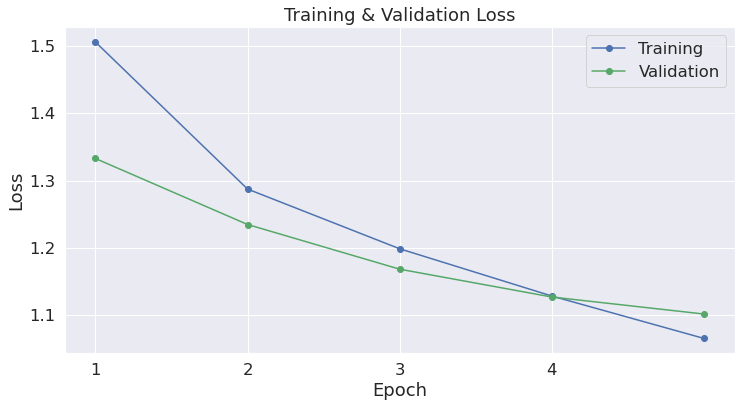

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/')

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save-scitech-headlines'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save-scitech-headlines


('./model_save-scitech-headlines/tokenizer_config.json',
 './model_save-scitech-headlines/special_tokens_map.json',
 './model_save-scitech-headlines/vocab.json',
 './model_save-scitech-headlines/merges.txt',
 './model_save-scitech-headlines/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save-scitech-headlines/

total 499792K
-rw-rw-r-- 1 saifhassan saifhassan      1K اکتوب  8 22:00 added_tokens.json
-rw-rw-r-- 1 saifhassan saifhassan      1K اکتوب  8 22:00 config.json
-rw-rw-r-- 1 saifhassan saifhassan    446K اکتوب  8 22:00 merges.txt
-rw-rw-r-- 1 saifhassan saifhassan 498448K اکتوب  8 22:00 pytorch_model.bin
-rw-rw-r-- 1 saifhassan saifhassan      1K اکتوب  8 22:00 special_tokens_map.json
-rw-rw-r-- 1 saifhassan saifhassan      1K اکتوب  8 22:00 tokenizer_config.json
-rw-rw-r-- 1 saifhassan saifhassan    878K اکتوب  8 22:00 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save-scitech-headlines/pytorch_model.bin

-rw-rw-r-- 1 saifhassan saifhassan 487M اکتوب  8 22:00 ./model_save-scitech-headlines/pytorch_model.bin


# Generate Text

In [ ]:
# Copy the model files to a directory in your Google Drive.
#!cp -r ./model_save-design/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
output_dir = 'code/model_save-scitech-headlines/'
#device = torch.device("cuda")
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
#generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 100,
                                top_p=0.95, 
                                num_return_sequences=100
                                )

f = open("scitech-headlines.txt", "a")

for i, sample_output in enumerate(sample_outputs):
    text = tokenizer.decode(sample_output, skip_special_tokens=True)
    print("{}: {}\n\n".format(i, text))
    f.write(str(i) + ". " + text + "\n\n")
f.close()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]])
0: برطانیہ نووقات کانوام ھانادری پولات ت ام باتضر چول چو چوچوگگی ام موام ت ت گام موبا رو


1: پاکستان میں کی میکیریا فوچیٹر کاٹرو سی موی نیٹیپتا ا ساتنیور سرسادروی می نیفر


2: زیتون کاو لوکے مزانیفانی سمارورکا کیز نیٹ انا کیگ گلیزمعینیک نیو کار رنیم


3: گوگل پلس کسی بکس کسی پلاسپرامینی کی ک کی ا ای کی ک مز ک ک نیپر ک ک جی ک 


4: سونی کا نی خریلا مہ مرا چیجلاس ویشنہرک وانہاٹنپیفرکرز کرد کشدری کل صرز مزگیم


5: جسم میں پاگا پں پروت ان گلایفوگ گیزیٹر گو ج گوگیزیٹیو انیونیٹیٹر پ گ اس و


6: شیشے کی �ائے چیورب سمہائہائیورینجیٹ ٹیٹروک پنی رو ڈی سٹرزیٹی رونیٹیٹ�


7: یادداشت جلاعملی عتہ کلادی بیولابی ڑیسقاد حمات ری گ نگہے دی گیوھن گان مے گ بی �


8: جنوبی کوروٹیپنفلائٹ چوکنیٹ جکورنزمبیفیٹر کر کلیٹر اقی ڈنیفل اقتیپنی�


9: جراثیم کیعلشفی ڈیارائی کی ری روڈ یوکفو کٹ کٹسٹیفونی صار سٹ ککٹی سٹ �


10: سال کے خطور کانجورنطی بک سولائی خر ڈ پی ب نی دور گکے تیپر گیپگیپے سی پور پ�


11: تحریک انوروگہائی می ک کانگ گدگگی ستنی من می پرچی خاشنہ منی چہ نی پگہری ت پری


12: چین نے کسامری 